In [1]:
!pwd

/home/dina/Documents/repos/paper_greekparliament/src


In [2]:
import pandas as pd
from tqdm import tqdm
import numpy as np
import datetime
import re
import os
tqdm.pandas()
from cade.cade import CADE
from gensim.models.word2vec import Word2Vec
from scipy.spatial.distance import cosine, euclidean
from sklearn.metrics.pairwise import cosine_similarity
import tqdm.notebook as tq
from tabulate import tabulate


In [3]:
df = pd.read_csv('../out_files/tell_all_cleaned.csv')

print(df.shape)
df = df[df['speech'].notna()]
print(df.shape)
df.speech.iloc[0]


(1280918, 12)
(1274505, 12)


'παρακαλειται @sw γραμματεας βουλγαρακης @sw συνοδευσει @sw μακαριοτατο αρχιεπισκοπο αθηνων @sw πασης ελλαδος σεραφειμ @sw @sw συνοδευοντα @sw μελη @sw ιερας συνοδου @sw @sw εισοδο @sw @sw αιθουσα @sw βουλης @sw @sw τελεσθει αγιασμος.@sw συνεχεια τελειται @sw καθιερωμενος αγιασμος'

In [4]:
df.sitting_date = pd.to_datetime(df.sitting_date, format="%d/%m/%Y") 
df.speech.head(4)

0    παρακαλειται @sw γραμματεας βουλγαρακης @sw συ...
1    παρακαλειται @sw κυριος γραμματεας @sw συνοδευ...
2    κυριοι συναδελφοι παρακαλω @sw βουλη @sw εξουσ...
3                                              @sw @sw
Name: speech, dtype: object

In [5]:
#New column year
df['year'] = df['sitting_date'].dt.year
print(datetime.datetime.now())
#Group speeches by year

'''
cade tool uses gensim.models.word2vec.LineSentence() to iterate over the training corpus
gensim.models.word2vec.LineSentence() takes as input 
a file that contains sentences: one line = one sentence.
Words must be already preprocessed and separated by whitespace'''
df.speech = df.speech+' . '
df.speech = df.speech.progress_apply(lambda x: x.replace('\n', ' '))
df.speech = df.speech.progress_apply(lambda x: re.sub('\s\s+' , ' ', x))  
df.speech = df.speech.progress_apply(lambda x: x.replace(".", " . ")) #add space around dot
df.speech = df.speech.progress_apply(lambda x: x.replace('. ', '. \n'))

PERyear_df = df.copy().groupby(df.year)['speech'].progress_apply(''.join).reset_index() #concat sentences, each last sentence for each speech did not have dot so add one.
print(datetime.datetime.now())



2021-10-08 19:11:53.467596


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 31/31 [00:00<00:00, 46.97it/s]

2021-10-08 19:12:11.288656


In [7]:
# print(PERyear_df.speech.iloc[0][:1000])

Create file per year

In [6]:
training_texts_dir = 'training_texts/'
if not os.path.exists(training_texts_dir):
    os.makedirs(training_texts_dir)

for year, speech in tqdm(zip(PERyear_df.year, PERyear_df.speech)):
#     print(year)
    with open(training_texts_dir+str(year)+'.txt', "w") as o:
        o.write(speech)      

31it [00:02, 13.75it/s]


In [16]:
# PERyear_df.speech = PERyear_df.speech.progress_apply(lambda x: x[:500])
# print(len(PERyear_df.speech.iloc[0]))

In [17]:
# annual_speech_pd.apply(len).plot(kind="bar");

Train aligned models with compass (lasts for almost three hours)

In [7]:
def compute_cosine_similarity(model1,model2,word):
    vector1 = model1.wv[word].reshape(1,-1)
    vector2 = model2.wv[word].reshape(1,-1)
    return(cosine_similarity(X=vector1, Y=vector2)[0][0])

def step_one_pairs(list_of_items):
    return [(list_of_items[i],list_of_items[i+1]) for i in range(len(list_of_items)-1)]


In [18]:
print(datetime.datetime.now())
          
#sort dataframe by year
PERyear_df.sort_values(by='year')
years = sorted(PERyear_df.year.to_list())
year_pairs = step_one_pairs(years)

swifts_PERyear_list=[]

# aligned_models_per_year = {y:Word2Vec.load(align_dest_dir+str(y)+'.mdl') for y in years}


for pair in tqdm(year_pairs):
    year_1, year_2 = str(pair[0]),str(pair[1])
    print(pair)
    compass_file_path = training_texts_dir+str(year_1)+'.'+str(year_2)+'.txt'
    with open(compass_file_path, "w") as o:
        o.write(open(training_texts_dir+year_1+'.txt').read()+"\n"+open(training_texts_dir+year_2+'.txt').read())
    
    aligner = CADE(size=30, siter=10, diter=10, workers=4)
    aligner.train_compass(compass_file_path, overwrite=True, save=True)
    m1 = aligner.train_slice(training_texts_dir+year_1+'.txt', save=True)
    m2 = aligner.train_slice(training_texts_dir+year_2+'.txt', save=True)
#     print(type(slice_one))
    
#     m1 = Word2Vec.load(f"model/{year_1}.model")
#     m2 = Word2Vec.load(f"model/{year_2}.model")

    common_vocab = list(set(m1.wv.vocab).intersection(set(m2.wv.vocab)))
    print(len(common_vocab))

    for word in tq.tqdm(common_vocab):

        cos_sim = compute_cosine_similarity(m1, m2, word)
        swifts_PERyear_list.append([pair, word, cos_sim, len(common_vocab)])

print(datetime.datetime.now())


  0%|          | 0/30 [00:00<?, ?it/s]

2021-02-05 16:45:12.481935
(1989, 1990)
Training the compass from scratch.
Current saved compass will be overwritten after training


/Users/furiosa/Documents/repos/paper_greekparliament/.compass/lib/python3.7/site-packages/smart_open/smart_open_lib.py:410: UserWarning: This function is deprecated, use smart_open.open instead. See the migration notes for details: https://github.com/RaRe-Technologies/smart_open/blob/master/README.rst#migrating-to-the-new-open-function
  'See the migration notes for details: %s' % _MIGRATION_NOTES_URL
/Users/furiosa/Documents/repos/paper_greekparliament/.compass/lib/python3.7/site-packages/smart_open/smart_open_lib.py:410: UserWarning: This function is deprecated, use smart_open.open instead. See the migration notes for details: https://github.com/RaRe-Technologies/smart_open/blob/master/README.rst#migrating-to-the-new-open-function
  'See the migration notes for details: %s' % _MIGRATION_NOTES_URL


Training embeddings: slice training_texts/1989.txt.


/Users/furiosa/Documents/repos/paper_greekparliament/.compass/lib/python3.7/site-packages/smart_open/smart_open_lib.py:410: UserWarning: This function is deprecated, use smart_open.open instead. See the migration notes for details: https://github.com/RaRe-Technologies/smart_open/blob/master/README.rst#migrating-to-the-new-open-function
  'See the migration notes for details: %s' % _MIGRATION_NOTES_URL


Initializing embeddings from compass.


/Users/furiosa/Documents/repos/paper_greekparliament/.compass/lib/python3.7/site-packages/smart_open/smart_open_lib.py:410: UserWarning: This function is deprecated, use smart_open.open instead. See the migration notes for details: https://github.com/RaRe-Technologies/smart_open/blob/master/README.rst#migrating-to-the-new-open-function
  'See the migration notes for details: %s' % _MIGRATION_NOTES_URL
/Users/furiosa/Documents/repos/paper_greekparliament/.compass/lib/python3.7/site-packages/smart_open/smart_open_lib.py:410: UserWarning: This function is deprecated, use smart_open.open instead. See the migration notes for details: https://github.com/RaRe-Technologies/smart_open/blob/master/README.rst#migrating-to-the-new-open-function
  'See the migration notes for details: %s' % _MIGRATION_NOTES_URL


Training embeddings: slice training_texts/1990.txt.
Initializing embeddings from compass.
31656


/Users/furiosa/Documents/repos/paper_greekparliament/.compass/lib/python3.7/site-packages/smart_open/smart_open_lib.py:410: UserWarning: This function is deprecated, use smart_open.open instead. See the migration notes for details: https://github.com/RaRe-Technologies/smart_open/blob/master/README.rst#migrating-to-the-new-open-function
  'See the migration notes for details: %s' % _MIGRATION_NOTES_URL


  0%|          | 0/31656 [00:00<?, ?it/s]

  3%|▎         | 1/30 [04:48<2:19:40, 288.99s/it]

(1990, 1991)
Training the compass from scratch.
Current saved compass will be overwritten after training


/Users/furiosa/Documents/repos/paper_greekparliament/.compass/lib/python3.7/site-packages/smart_open/smart_open_lib.py:410: UserWarning: This function is deprecated, use smart_open.open instead. See the migration notes for details: https://github.com/RaRe-Technologies/smart_open/blob/master/README.rst#migrating-to-the-new-open-function
  'See the migration notes for details: %s' % _MIGRATION_NOTES_URL
/Users/furiosa/Documents/repos/paper_greekparliament/.compass/lib/python3.7/site-packages/smart_open/smart_open_lib.py:410: UserWarning: This function is deprecated, use smart_open.open instead. See the migration notes for details: https://github.com/RaRe-Technologies/smart_open/blob/master/README.rst#migrating-to-the-new-open-function
  'See the migration notes for details: %s' % _MIGRATION_NOTES_URL


Training embeddings: slice training_texts/1990.txt.


/Users/furiosa/Documents/repos/paper_greekparliament/.compass/lib/python3.7/site-packages/smart_open/smart_open_lib.py:410: UserWarning: This function is deprecated, use smart_open.open instead. See the migration notes for details: https://github.com/RaRe-Technologies/smart_open/blob/master/README.rst#migrating-to-the-new-open-function
  'See the migration notes for details: %s' % _MIGRATION_NOTES_URL


Initializing embeddings from compass.


/Users/furiosa/Documents/repos/paper_greekparliament/.compass/lib/python3.7/site-packages/smart_open/smart_open_lib.py:410: UserWarning: This function is deprecated, use smart_open.open instead. See the migration notes for details: https://github.com/RaRe-Technologies/smart_open/blob/master/README.rst#migrating-to-the-new-open-function
  'See the migration notes for details: %s' % _MIGRATION_NOTES_URL


Training embeddings: slice training_texts/1991.txt.


/Users/furiosa/Documents/repos/paper_greekparliament/.compass/lib/python3.7/site-packages/smart_open/smart_open_lib.py:410: UserWarning: This function is deprecated, use smart_open.open instead. See the migration notes for details: https://github.com/RaRe-Technologies/smart_open/blob/master/README.rst#migrating-to-the-new-open-function
  'See the migration notes for details: %s' % _MIGRATION_NOTES_URL


Initializing embeddings from compass.


/Users/furiosa/Documents/repos/paper_greekparliament/.compass/lib/python3.7/site-packages/smart_open/smart_open_lib.py:410: UserWarning: This function is deprecated, use smart_open.open instead. See the migration notes for details: https://github.com/RaRe-Technologies/smart_open/blob/master/README.rst#migrating-to-the-new-open-function
  'See the migration notes for details: %s' % _MIGRATION_NOTES_URL


46638


  0%|          | 0/46638 [00:00<?, ?it/s]

  7%|▋         | 2/30 [13:58<3:26:27, 442.42s/it]

(1991, 1992)
Training the compass from scratch.
Current saved compass will be overwritten after training


/Users/furiosa/Documents/repos/paper_greekparliament/.compass/lib/python3.7/site-packages/smart_open/smart_open_lib.py:410: UserWarning: This function is deprecated, use smart_open.open instead. See the migration notes for details: https://github.com/RaRe-Technologies/smart_open/blob/master/README.rst#migrating-to-the-new-open-function
  'See the migration notes for details: %s' % _MIGRATION_NOTES_URL
/Users/furiosa/Documents/repos/paper_greekparliament/.compass/lib/python3.7/site-packages/smart_open/smart_open_lib.py:410: UserWarning: This function is deprecated, use smart_open.open instead. See the migration notes for details: https://github.com/RaRe-Technologies/smart_open/blob/master/README.rst#migrating-to-the-new-open-function
  'See the migration notes for details: %s' % _MIGRATION_NOTES_URL


Training embeddings: slice training_texts/1991.txt.


/Users/furiosa/Documents/repos/paper_greekparliament/.compass/lib/python3.7/site-packages/smart_open/smart_open_lib.py:410: UserWarning: This function is deprecated, use smart_open.open instead. See the migration notes for details: https://github.com/RaRe-Technologies/smart_open/blob/master/README.rst#migrating-to-the-new-open-function
  'See the migration notes for details: %s' % _MIGRATION_NOTES_URL


Initializing embeddings from compass.


/Users/furiosa/Documents/repos/paper_greekparliament/.compass/lib/python3.7/site-packages/smart_open/smart_open_lib.py:410: UserWarning: This function is deprecated, use smart_open.open instead. See the migration notes for details: https://github.com/RaRe-Technologies/smart_open/blob/master/README.rst#migrating-to-the-new-open-function
  'See the migration notes for details: %s' % _MIGRATION_NOTES_URL


Training embeddings: slice training_texts/1992.txt.


/Users/furiosa/Documents/repos/paper_greekparliament/.compass/lib/python3.7/site-packages/smart_open/smart_open_lib.py:410: UserWarning: This function is deprecated, use smart_open.open instead. See the migration notes for details: https://github.com/RaRe-Technologies/smart_open/blob/master/README.rst#migrating-to-the-new-open-function
  'See the migration notes for details: %s' % _MIGRATION_NOTES_URL


Initializing embeddings from compass.


/Users/furiosa/Documents/repos/paper_greekparliament/.compass/lib/python3.7/site-packages/smart_open/smart_open_lib.py:410: UserWarning: This function is deprecated, use smart_open.open instead. See the migration notes for details: https://github.com/RaRe-Technologies/smart_open/blob/master/README.rst#migrating-to-the-new-open-function
  'See the migration notes for details: %s' % _MIGRATION_NOTES_URL


52582


  0%|          | 0/52582 [00:00<?, ?it/s]

 10%|█         | 3/30 [23:18<3:43:13, 496.06s/it]

(1992, 1993)
Training the compass from scratch.
Current saved compass will be overwritten after training


/Users/furiosa/Documents/repos/paper_greekparliament/.compass/lib/python3.7/site-packages/smart_open/smart_open_lib.py:410: UserWarning: This function is deprecated, use smart_open.open instead. See the migration notes for details: https://github.com/RaRe-Technologies/smart_open/blob/master/README.rst#migrating-to-the-new-open-function
  'See the migration notes for details: %s' % _MIGRATION_NOTES_URL
/Users/furiosa/Documents/repos/paper_greekparliament/.compass/lib/python3.7/site-packages/smart_open/smart_open_lib.py:410: UserWarning: This function is deprecated, use smart_open.open instead. See the migration notes for details: https://github.com/RaRe-Technologies/smart_open/blob/master/README.rst#migrating-to-the-new-open-function
  'See the migration notes for details: %s' % _MIGRATION_NOTES_URL


Training embeddings: slice training_texts/1992.txt.


/Users/furiosa/Documents/repos/paper_greekparliament/.compass/lib/python3.7/site-packages/smart_open/smart_open_lib.py:410: UserWarning: This function is deprecated, use smart_open.open instead. See the migration notes for details: https://github.com/RaRe-Technologies/smart_open/blob/master/README.rst#migrating-to-the-new-open-function
  'See the migration notes for details: %s' % _MIGRATION_NOTES_URL


Initializing embeddings from compass.


/Users/furiosa/Documents/repos/paper_greekparliament/.compass/lib/python3.7/site-packages/smart_open/smart_open_lib.py:410: UserWarning: This function is deprecated, use smart_open.open instead. See the migration notes for details: https://github.com/RaRe-Technologies/smart_open/blob/master/README.rst#migrating-to-the-new-open-function
  'See the migration notes for details: %s' % _MIGRATION_NOTES_URL


Training embeddings: slice training_texts/1993.txt.


/Users/furiosa/Documents/repos/paper_greekparliament/.compass/lib/python3.7/site-packages/smart_open/smart_open_lib.py:410: UserWarning: This function is deprecated, use smart_open.open instead. See the migration notes for details: https://github.com/RaRe-Technologies/smart_open/blob/master/README.rst#migrating-to-the-new-open-function
  'See the migration notes for details: %s' % _MIGRATION_NOTES_URL


Initializing embeddings from compass.


/Users/furiosa/Documents/repos/paper_greekparliament/.compass/lib/python3.7/site-packages/smart_open/smart_open_lib.py:410: UserWarning: This function is deprecated, use smart_open.open instead. See the migration notes for details: https://github.com/RaRe-Technologies/smart_open/blob/master/README.rst#migrating-to-the-new-open-function
  'See the migration notes for details: %s' % _MIGRATION_NOTES_URL


52344


  0%|          | 0/52344 [00:00<?, ?it/s]

 13%|█▎        | 4/30 [31:37<3:35:24, 497.08s/it]

(1993, 1994)
Training the compass from scratch.
Current saved compass will be overwritten after training


/Users/furiosa/Documents/repos/paper_greekparliament/.compass/lib/python3.7/site-packages/smart_open/smart_open_lib.py:410: UserWarning: This function is deprecated, use smart_open.open instead. See the migration notes for details: https://github.com/RaRe-Technologies/smart_open/blob/master/README.rst#migrating-to-the-new-open-function
  'See the migration notes for details: %s' % _MIGRATION_NOTES_URL
/Users/furiosa/Documents/repos/paper_greekparliament/.compass/lib/python3.7/site-packages/smart_open/smart_open_lib.py:410: UserWarning: This function is deprecated, use smart_open.open instead. See the migration notes for details: https://github.com/RaRe-Technologies/smart_open/blob/master/README.rst#migrating-to-the-new-open-function
  'See the migration notes for details: %s' % _MIGRATION_NOTES_URL


Training embeddings: slice training_texts/1993.txt.


/Users/furiosa/Documents/repos/paper_greekparliament/.compass/lib/python3.7/site-packages/smart_open/smart_open_lib.py:410: UserWarning: This function is deprecated, use smart_open.open instead. See the migration notes for details: https://github.com/RaRe-Technologies/smart_open/blob/master/README.rst#migrating-to-the-new-open-function
  'See the migration notes for details: %s' % _MIGRATION_NOTES_URL


Initializing embeddings from compass.


/Users/furiosa/Documents/repos/paper_greekparliament/.compass/lib/python3.7/site-packages/smart_open/smart_open_lib.py:410: UserWarning: This function is deprecated, use smart_open.open instead. See the migration notes for details: https://github.com/RaRe-Technologies/smart_open/blob/master/README.rst#migrating-to-the-new-open-function
  'See the migration notes for details: %s' % _MIGRATION_NOTES_URL


Training embeddings: slice training_texts/1994.txt.


/Users/furiosa/Documents/repos/paper_greekparliament/.compass/lib/python3.7/site-packages/smart_open/smart_open_lib.py:410: UserWarning: This function is deprecated, use smart_open.open instead. See the migration notes for details: https://github.com/RaRe-Technologies/smart_open/blob/master/README.rst#migrating-to-the-new-open-function
  'See the migration notes for details: %s' % _MIGRATION_NOTES_URL


Initializing embeddings from compass.


/Users/furiosa/Documents/repos/paper_greekparliament/.compass/lib/python3.7/site-packages/smart_open/smart_open_lib.py:410: UserWarning: This function is deprecated, use smart_open.open instead. See the migration notes for details: https://github.com/RaRe-Technologies/smart_open/blob/master/README.rst#migrating-to-the-new-open-function
  'See the migration notes for details: %s' % _MIGRATION_NOTES_URL


45337


  0%|          | 0/45337 [00:00<?, ?it/s]

 17%|█▋        | 5/30 [37:17<3:03:33, 440.56s/it]

(1994, 1996)
Training the compass from scratch.
Current saved compass will be overwritten after training


/Users/furiosa/Documents/repos/paper_greekparliament/.compass/lib/python3.7/site-packages/smart_open/smart_open_lib.py:410: UserWarning: This function is deprecated, use smart_open.open instead. See the migration notes for details: https://github.com/RaRe-Technologies/smart_open/blob/master/README.rst#migrating-to-the-new-open-function
  'See the migration notes for details: %s' % _MIGRATION_NOTES_URL
/Users/furiosa/Documents/repos/paper_greekparliament/.compass/lib/python3.7/site-packages/smart_open/smart_open_lib.py:410: UserWarning: This function is deprecated, use smart_open.open instead. See the migration notes for details: https://github.com/RaRe-Technologies/smart_open/blob/master/README.rst#migrating-to-the-new-open-function
  'See the migration notes for details: %s' % _MIGRATION_NOTES_URL
/Users/furiosa/Documents/repos/paper_greekparliament/.compass/lib/python3.7/site-packages/smart_open/smart_open_lib.py:410: UserWarning: This function is deprecated, use smart_open.open inst

Training embeddings: slice training_texts/1994.txt.
Initializing embeddings from compass.


/Users/furiosa/Documents/repos/paper_greekparliament/.compass/lib/python3.7/site-packages/smart_open/smart_open_lib.py:410: UserWarning: This function is deprecated, use smart_open.open instead. See the migration notes for details: https://github.com/RaRe-Technologies/smart_open/blob/master/README.rst#migrating-to-the-new-open-function
  'See the migration notes for details: %s' % _MIGRATION_NOTES_URL
/Users/furiosa/Documents/repos/paper_greekparliament/.compass/lib/python3.7/site-packages/smart_open/smart_open_lib.py:410: UserWarning: This function is deprecated, use smart_open.open instead. See the migration notes for details: https://github.com/RaRe-Technologies/smart_open/blob/master/README.rst#migrating-to-the-new-open-function
  'See the migration notes for details: %s' % _MIGRATION_NOTES_URL


Training embeddings: slice training_texts/1996.txt.
Initializing embeddings from compass.


/Users/furiosa/Documents/repos/paper_greekparliament/.compass/lib/python3.7/site-packages/smart_open/smart_open_lib.py:410: UserWarning: This function is deprecated, use smart_open.open instead. See the migration notes for details: https://github.com/RaRe-Technologies/smart_open/blob/master/README.rst#migrating-to-the-new-open-function
  'See the migration notes for details: %s' % _MIGRATION_NOTES_URL


31532


  0%|          | 0/31532 [00:00<?, ?it/s]

 20%|██        | 6/30 [40:43<2:24:19, 360.81s/it]

(1996, 1997)
Training the compass from scratch.
Current saved compass will be overwritten after training


/Users/furiosa/Documents/repos/paper_greekparliament/.compass/lib/python3.7/site-packages/smart_open/smart_open_lib.py:410: UserWarning: This function is deprecated, use smart_open.open instead. See the migration notes for details: https://github.com/RaRe-Technologies/smart_open/blob/master/README.rst#migrating-to-the-new-open-function
  'See the migration notes for details: %s' % _MIGRATION_NOTES_URL
/Users/furiosa/Documents/repos/paper_greekparliament/.compass/lib/python3.7/site-packages/smart_open/smart_open_lib.py:410: UserWarning: This function is deprecated, use smart_open.open instead. See the migration notes for details: https://github.com/RaRe-Technologies/smart_open/blob/master/README.rst#migrating-to-the-new-open-function
  'See the migration notes for details: %s' % _MIGRATION_NOTES_URL


Training embeddings: slice training_texts/1996.txt.


/Users/furiosa/Documents/repos/paper_greekparliament/.compass/lib/python3.7/site-packages/smart_open/smart_open_lib.py:410: UserWarning: This function is deprecated, use smart_open.open instead. See the migration notes for details: https://github.com/RaRe-Technologies/smart_open/blob/master/README.rst#migrating-to-the-new-open-function
  'See the migration notes for details: %s' % _MIGRATION_NOTES_URL


Initializing embeddings from compass.


/Users/furiosa/Documents/repos/paper_greekparliament/.compass/lib/python3.7/site-packages/smart_open/smart_open_lib.py:410: UserWarning: This function is deprecated, use smart_open.open instead. See the migration notes for details: https://github.com/RaRe-Technologies/smart_open/blob/master/README.rst#migrating-to-the-new-open-function
  'See the migration notes for details: %s' % _MIGRATION_NOTES_URL
/Users/furiosa/Documents/repos/paper_greekparliament/.compass/lib/python3.7/site-packages/smart_open/smart_open_lib.py:410: UserWarning: This function is deprecated, use smart_open.open instead. See the migration notes for details: https://github.com/RaRe-Technologies/smart_open/blob/master/README.rst#migrating-to-the-new-open-function
  'See the migration notes for details: %s' % _MIGRATION_NOTES_URL


Training embeddings: slice training_texts/1997.txt.
Initializing embeddings from compass.


/Users/furiosa/Documents/repos/paper_greekparliament/.compass/lib/python3.7/site-packages/smart_open/smart_open_lib.py:410: UserWarning: This function is deprecated, use smart_open.open instead. See the migration notes for details: https://github.com/RaRe-Technologies/smart_open/blob/master/README.rst#migrating-to-the-new-open-function
  'See the migration notes for details: %s' % _MIGRATION_NOTES_URL


35560


  0%|          | 0/35560 [00:00<?, ?it/s]

 23%|██▎       | 7/30 [45:22<2:08:05, 334.14s/it]

(1997, 1998)
Training the compass from scratch.
Current saved compass will be overwritten after training


/Users/furiosa/Documents/repos/paper_greekparliament/.compass/lib/python3.7/site-packages/smart_open/smart_open_lib.py:410: UserWarning: This function is deprecated, use smart_open.open instead. See the migration notes for details: https://github.com/RaRe-Technologies/smart_open/blob/master/README.rst#migrating-to-the-new-open-function
  'See the migration notes for details: %s' % _MIGRATION_NOTES_URL
/Users/furiosa/Documents/repos/paper_greekparliament/.compass/lib/python3.7/site-packages/smart_open/smart_open_lib.py:410: UserWarning: This function is deprecated, use smart_open.open instead. See the migration notes for details: https://github.com/RaRe-Technologies/smart_open/blob/master/README.rst#migrating-to-the-new-open-function
  'See the migration notes for details: %s' % _MIGRATION_NOTES_URL


Training embeddings: slice training_texts/1997.txt.


/Users/furiosa/Documents/repos/paper_greekparliament/.compass/lib/python3.7/site-packages/smart_open/smart_open_lib.py:410: UserWarning: This function is deprecated, use smart_open.open instead. See the migration notes for details: https://github.com/RaRe-Technologies/smart_open/blob/master/README.rst#migrating-to-the-new-open-function
  'See the migration notes for details: %s' % _MIGRATION_NOTES_URL


Initializing embeddings from compass.


/Users/furiosa/Documents/repos/paper_greekparliament/.compass/lib/python3.7/site-packages/smart_open/smart_open_lib.py:410: UserWarning: This function is deprecated, use smart_open.open instead. See the migration notes for details: https://github.com/RaRe-Technologies/smart_open/blob/master/README.rst#migrating-to-the-new-open-function
  'See the migration notes for details: %s' % _MIGRATION_NOTES_URL


Training embeddings: slice training_texts/1998.txt.


/Users/furiosa/Documents/repos/paper_greekparliament/.compass/lib/python3.7/site-packages/smart_open/smart_open_lib.py:410: UserWarning: This function is deprecated, use smart_open.open instead. See the migration notes for details: https://github.com/RaRe-Technologies/smart_open/blob/master/README.rst#migrating-to-the-new-open-function
  'See the migration notes for details: %s' % _MIGRATION_NOTES_URL


Initializing embeddings from compass.


/Users/furiosa/Documents/repos/paper_greekparliament/.compass/lib/python3.7/site-packages/smart_open/smart_open_lib.py:410: UserWarning: This function is deprecated, use smart_open.open instead. See the migration notes for details: https://github.com/RaRe-Technologies/smart_open/blob/master/README.rst#migrating-to-the-new-open-function
  'See the migration notes for details: %s' % _MIGRATION_NOTES_URL


44665


  0%|          | 0/44665 [00:00<?, ?it/s]

 27%|██▋       | 8/30 [51:07<2:03:43, 337.43s/it]

(1998, 1999)
Training the compass from scratch.
Current saved compass will be overwritten after training


/Users/furiosa/Documents/repos/paper_greekparliament/.compass/lib/python3.7/site-packages/smart_open/smart_open_lib.py:410: UserWarning: This function is deprecated, use smart_open.open instead. See the migration notes for details: https://github.com/RaRe-Technologies/smart_open/blob/master/README.rst#migrating-to-the-new-open-function
  'See the migration notes for details: %s' % _MIGRATION_NOTES_URL
/Users/furiosa/Documents/repos/paper_greekparliament/.compass/lib/python3.7/site-packages/smart_open/smart_open_lib.py:410: UserWarning: This function is deprecated, use smart_open.open instead. See the migration notes for details: https://github.com/RaRe-Technologies/smart_open/blob/master/README.rst#migrating-to-the-new-open-function
  'See the migration notes for details: %s' % _MIGRATION_NOTES_URL


Training embeddings: slice training_texts/1998.txt.


/Users/furiosa/Documents/repos/paper_greekparliament/.compass/lib/python3.7/site-packages/smart_open/smart_open_lib.py:410: UserWarning: This function is deprecated, use smart_open.open instead. See the migration notes for details: https://github.com/RaRe-Technologies/smart_open/blob/master/README.rst#migrating-to-the-new-open-function
  'See the migration notes for details: %s' % _MIGRATION_NOTES_URL


Initializing embeddings from compass.


/Users/furiosa/Documents/repos/paper_greekparliament/.compass/lib/python3.7/site-packages/smart_open/smart_open_lib.py:410: UserWarning: This function is deprecated, use smart_open.open instead. See the migration notes for details: https://github.com/RaRe-Technologies/smart_open/blob/master/README.rst#migrating-to-the-new-open-function
  'See the migration notes for details: %s' % _MIGRATION_NOTES_URL


Training embeddings: slice training_texts/1999.txt.


/Users/furiosa/Documents/repos/paper_greekparliament/.compass/lib/python3.7/site-packages/smart_open/smart_open_lib.py:410: UserWarning: This function is deprecated, use smart_open.open instead. See the migration notes for details: https://github.com/RaRe-Technologies/smart_open/blob/master/README.rst#migrating-to-the-new-open-function
  'See the migration notes for details: %s' % _MIGRATION_NOTES_URL


Initializing embeddings from compass.


/Users/furiosa/Documents/repos/paper_greekparliament/.compass/lib/python3.7/site-packages/smart_open/smart_open_lib.py:410: UserWarning: This function is deprecated, use smart_open.open instead. See the migration notes for details: https://github.com/RaRe-Technologies/smart_open/blob/master/README.rst#migrating-to-the-new-open-function
  'See the migration notes for details: %s' % _MIGRATION_NOTES_URL


42800


  0%|          | 0/42800 [00:00<?, ?it/s]

 30%|███       | 9/30 [57:23<2:02:16, 349.37s/it]

(1999, 2000)
Training the compass from scratch.
Current saved compass will be overwritten after training


/Users/furiosa/Documents/repos/paper_greekparliament/.compass/lib/python3.7/site-packages/smart_open/smart_open_lib.py:410: UserWarning: This function is deprecated, use smart_open.open instead. See the migration notes for details: https://github.com/RaRe-Technologies/smart_open/blob/master/README.rst#migrating-to-the-new-open-function
  'See the migration notes for details: %s' % _MIGRATION_NOTES_URL
/Users/furiosa/Documents/repos/paper_greekparliament/.compass/lib/python3.7/site-packages/smart_open/smart_open_lib.py:410: UserWarning: This function is deprecated, use smart_open.open instead. See the migration notes for details: https://github.com/RaRe-Technologies/smart_open/blob/master/README.rst#migrating-to-the-new-open-function
  'See the migration notes for details: %s' % _MIGRATION_NOTES_URL


Training embeddings: slice training_texts/1999.txt.


/Users/furiosa/Documents/repos/paper_greekparliament/.compass/lib/python3.7/site-packages/smart_open/smart_open_lib.py:410: UserWarning: This function is deprecated, use smart_open.open instead. See the migration notes for details: https://github.com/RaRe-Technologies/smart_open/blob/master/README.rst#migrating-to-the-new-open-function
  'See the migration notes for details: %s' % _MIGRATION_NOTES_URL


Initializing embeddings from compass.


/Users/furiosa/Documents/repos/paper_greekparliament/.compass/lib/python3.7/site-packages/smart_open/smart_open_lib.py:410: UserWarning: This function is deprecated, use smart_open.open instead. See the migration notes for details: https://github.com/RaRe-Technologies/smart_open/blob/master/README.rst#migrating-to-the-new-open-function
  'See the migration notes for details: %s' % _MIGRATION_NOTES_URL


Training embeddings: slice training_texts/2000.txt.


/Users/furiosa/Documents/repos/paper_greekparliament/.compass/lib/python3.7/site-packages/smart_open/smart_open_lib.py:410: UserWarning: This function is deprecated, use smart_open.open instead. See the migration notes for details: https://github.com/RaRe-Technologies/smart_open/blob/master/README.rst#migrating-to-the-new-open-function
  'See the migration notes for details: %s' % _MIGRATION_NOTES_URL


Initializing embeddings from compass.


/Users/furiosa/Documents/repos/paper_greekparliament/.compass/lib/python3.7/site-packages/smart_open/smart_open_lib.py:410: UserWarning: This function is deprecated, use smart_open.open instead. See the migration notes for details: https://github.com/RaRe-Technologies/smart_open/blob/master/README.rst#migrating-to-the-new-open-function
  'See the migration notes for details: %s' % _MIGRATION_NOTES_URL


43505


  0%|          | 0/43505 [00:00<?, ?it/s]

 33%|███▎      | 10/30 [1:04:42<2:05:43, 377.19s/it]

(2000, 2001)
Training the compass from scratch.
Current saved compass will be overwritten after training


/Users/furiosa/Documents/repos/paper_greekparliament/.compass/lib/python3.7/site-packages/smart_open/smart_open_lib.py:410: UserWarning: This function is deprecated, use smart_open.open instead. See the migration notes for details: https://github.com/RaRe-Technologies/smart_open/blob/master/README.rst#migrating-to-the-new-open-function
  'See the migration notes for details: %s' % _MIGRATION_NOTES_URL
/Users/furiosa/Documents/repos/paper_greekparliament/.compass/lib/python3.7/site-packages/smart_open/smart_open_lib.py:410: UserWarning: This function is deprecated, use smart_open.open instead. See the migration notes for details: https://github.com/RaRe-Technologies/smart_open/blob/master/README.rst#migrating-to-the-new-open-function
  'See the migration notes for details: %s' % _MIGRATION_NOTES_URL


Training embeddings: slice training_texts/2000.txt.


/Users/furiosa/Documents/repos/paper_greekparliament/.compass/lib/python3.7/site-packages/smart_open/smart_open_lib.py:410: UserWarning: This function is deprecated, use smart_open.open instead. See the migration notes for details: https://github.com/RaRe-Technologies/smart_open/blob/master/README.rst#migrating-to-the-new-open-function
  'See the migration notes for details: %s' % _MIGRATION_NOTES_URL


Initializing embeddings from compass.


/Users/furiosa/Documents/repos/paper_greekparliament/.compass/lib/python3.7/site-packages/smart_open/smart_open_lib.py:410: UserWarning: This function is deprecated, use smart_open.open instead. See the migration notes for details: https://github.com/RaRe-Technologies/smart_open/blob/master/README.rst#migrating-to-the-new-open-function
  'See the migration notes for details: %s' % _MIGRATION_NOTES_URL


Training embeddings: slice training_texts/2001.txt.


/Users/furiosa/Documents/repos/paper_greekparliament/.compass/lib/python3.7/site-packages/smart_open/smart_open_lib.py:410: UserWarning: This function is deprecated, use smart_open.open instead. See the migration notes for details: https://github.com/RaRe-Technologies/smart_open/blob/master/README.rst#migrating-to-the-new-open-function
  'See the migration notes for details: %s' % _MIGRATION_NOTES_URL


Initializing embeddings from compass.


/Users/furiosa/Documents/repos/paper_greekparliament/.compass/lib/python3.7/site-packages/smart_open/smart_open_lib.py:410: UserWarning: This function is deprecated, use smart_open.open instead. See the migration notes for details: https://github.com/RaRe-Technologies/smart_open/blob/master/README.rst#migrating-to-the-new-open-function
  'See the migration notes for details: %s' % _MIGRATION_NOTES_URL


46073


  0%|          | 0/46073 [00:00<?, ?it/s]

 37%|███▋      | 11/30 [1:12:35<2:08:46, 406.66s/it]

(2001, 2002)
Training the compass from scratch.
Current saved compass will be overwritten after training


/Users/furiosa/Documents/repos/paper_greekparliament/.compass/lib/python3.7/site-packages/smart_open/smart_open_lib.py:410: UserWarning: This function is deprecated, use smart_open.open instead. See the migration notes for details: https://github.com/RaRe-Technologies/smart_open/blob/master/README.rst#migrating-to-the-new-open-function
  'See the migration notes for details: %s' % _MIGRATION_NOTES_URL
/Users/furiosa/Documents/repos/paper_greekparliament/.compass/lib/python3.7/site-packages/smart_open/smart_open_lib.py:410: UserWarning: This function is deprecated, use smart_open.open instead. See the migration notes for details: https://github.com/RaRe-Technologies/smart_open/blob/master/README.rst#migrating-to-the-new-open-function
  'See the migration notes for details: %s' % _MIGRATION_NOTES_URL


Training embeddings: slice training_texts/2001.txt.


/Users/furiosa/Documents/repos/paper_greekparliament/.compass/lib/python3.7/site-packages/smart_open/smart_open_lib.py:410: UserWarning: This function is deprecated, use smart_open.open instead. See the migration notes for details: https://github.com/RaRe-Technologies/smart_open/blob/master/README.rst#migrating-to-the-new-open-function
  'See the migration notes for details: %s' % _MIGRATION_NOTES_URL


Initializing embeddings from compass.


/Users/furiosa/Documents/repos/paper_greekparliament/.compass/lib/python3.7/site-packages/smart_open/smart_open_lib.py:410: UserWarning: This function is deprecated, use smart_open.open instead. See the migration notes for details: https://github.com/RaRe-Technologies/smart_open/blob/master/README.rst#migrating-to-the-new-open-function
  'See the migration notes for details: %s' % _MIGRATION_NOTES_URL


Training embeddings: slice training_texts/2002.txt.


/Users/furiosa/Documents/repos/paper_greekparliament/.compass/lib/python3.7/site-packages/smart_open/smart_open_lib.py:410: UserWarning: This function is deprecated, use smart_open.open instead. See the migration notes for details: https://github.com/RaRe-Technologies/smart_open/blob/master/README.rst#migrating-to-the-new-open-function
  'See the migration notes for details: %s' % _MIGRATION_NOTES_URL


Initializing embeddings from compass.


/Users/furiosa/Documents/repos/paper_greekparliament/.compass/lib/python3.7/site-packages/smart_open/smart_open_lib.py:410: UserWarning: This function is deprecated, use smart_open.open instead. See the migration notes for details: https://github.com/RaRe-Technologies/smart_open/blob/master/README.rst#migrating-to-the-new-open-function
  'See the migration notes for details: %s' % _MIGRATION_NOTES_URL


46595


  0%|          | 0/46595 [00:00<?, ?it/s]

 40%|████      | 12/30 [1:19:05<2:00:25, 401.43s/it]

(2002, 2003)
Training the compass from scratch.
Current saved compass will be overwritten after training


/Users/furiosa/Documents/repos/paper_greekparliament/.compass/lib/python3.7/site-packages/smart_open/smart_open_lib.py:410: UserWarning: This function is deprecated, use smart_open.open instead. See the migration notes for details: https://github.com/RaRe-Technologies/smart_open/blob/master/README.rst#migrating-to-the-new-open-function
  'See the migration notes for details: %s' % _MIGRATION_NOTES_URL
/Users/furiosa/Documents/repos/paper_greekparliament/.compass/lib/python3.7/site-packages/smart_open/smart_open_lib.py:410: UserWarning: This function is deprecated, use smart_open.open instead. See the migration notes for details: https://github.com/RaRe-Technologies/smart_open/blob/master/README.rst#migrating-to-the-new-open-function
  'See the migration notes for details: %s' % _MIGRATION_NOTES_URL


Training embeddings: slice training_texts/2002.txt.


/Users/furiosa/Documents/repos/paper_greekparliament/.compass/lib/python3.7/site-packages/smart_open/smart_open_lib.py:410: UserWarning: This function is deprecated, use smart_open.open instead. See the migration notes for details: https://github.com/RaRe-Technologies/smart_open/blob/master/README.rst#migrating-to-the-new-open-function
  'See the migration notes for details: %s' % _MIGRATION_NOTES_URL


Initializing embeddings from compass.


/Users/furiosa/Documents/repos/paper_greekparliament/.compass/lib/python3.7/site-packages/smart_open/smart_open_lib.py:410: UserWarning: This function is deprecated, use smart_open.open instead. See the migration notes for details: https://github.com/RaRe-Technologies/smart_open/blob/master/README.rst#migrating-to-the-new-open-function
  'See the migration notes for details: %s' % _MIGRATION_NOTES_URL


Training embeddings: slice training_texts/2003.txt.


/Users/furiosa/Documents/repos/paper_greekparliament/.compass/lib/python3.7/site-packages/smart_open/smart_open_lib.py:410: UserWarning: This function is deprecated, use smart_open.open instead. See the migration notes for details: https://github.com/RaRe-Technologies/smart_open/blob/master/README.rst#migrating-to-the-new-open-function
  'See the migration notes for details: %s' % _MIGRATION_NOTES_URL


Initializing embeddings from compass.


/Users/furiosa/Documents/repos/paper_greekparliament/.compass/lib/python3.7/site-packages/smart_open/smart_open_lib.py:410: UserWarning: This function is deprecated, use smart_open.open instead. See the migration notes for details: https://github.com/RaRe-Technologies/smart_open/blob/master/README.rst#migrating-to-the-new-open-function
  'See the migration notes for details: %s' % _MIGRATION_NOTES_URL


43661


  0%|          | 0/43661 [00:00<?, ?it/s]

 43%|████▎     | 13/30 [1:24:52<1:49:01, 384.81s/it]

(2003, 2004)
Training the compass from scratch.
Current saved compass will be overwritten after training


/Users/furiosa/Documents/repos/paper_greekparliament/.compass/lib/python3.7/site-packages/smart_open/smart_open_lib.py:410: UserWarning: This function is deprecated, use smart_open.open instead. See the migration notes for details: https://github.com/RaRe-Technologies/smart_open/blob/master/README.rst#migrating-to-the-new-open-function
  'See the migration notes for details: %s' % _MIGRATION_NOTES_URL
/Users/furiosa/Documents/repos/paper_greekparliament/.compass/lib/python3.7/site-packages/smart_open/smart_open_lib.py:410: UserWarning: This function is deprecated, use smart_open.open instead. See the migration notes for details: https://github.com/RaRe-Technologies/smart_open/blob/master/README.rst#migrating-to-the-new-open-function
  'See the migration notes for details: %s' % _MIGRATION_NOTES_URL


Training embeddings: slice training_texts/2003.txt.


/Users/furiosa/Documents/repos/paper_greekparliament/.compass/lib/python3.7/site-packages/smart_open/smart_open_lib.py:410: UserWarning: This function is deprecated, use smart_open.open instead. See the migration notes for details: https://github.com/RaRe-Technologies/smart_open/blob/master/README.rst#migrating-to-the-new-open-function
  'See the migration notes for details: %s' % _MIGRATION_NOTES_URL


Initializing embeddings from compass.


/Users/furiosa/Documents/repos/paper_greekparliament/.compass/lib/python3.7/site-packages/smart_open/smart_open_lib.py:410: UserWarning: This function is deprecated, use smart_open.open instead. See the migration notes for details: https://github.com/RaRe-Technologies/smart_open/blob/master/README.rst#migrating-to-the-new-open-function
  'See the migration notes for details: %s' % _MIGRATION_NOTES_URL


Training embeddings: slice training_texts/2004.txt.


/Users/furiosa/Documents/repos/paper_greekparliament/.compass/lib/python3.7/site-packages/smart_open/smart_open_lib.py:410: UserWarning: This function is deprecated, use smart_open.open instead. See the migration notes for details: https://github.com/RaRe-Technologies/smart_open/blob/master/README.rst#migrating-to-the-new-open-function
  'See the migration notes for details: %s' % _MIGRATION_NOTES_URL


Initializing embeddings from compass.


/Users/furiosa/Documents/repos/paper_greekparliament/.compass/lib/python3.7/site-packages/smart_open/smart_open_lib.py:410: UserWarning: This function is deprecated, use smart_open.open instead. See the migration notes for details: https://github.com/RaRe-Technologies/smart_open/blob/master/README.rst#migrating-to-the-new-open-function
  'See the migration notes for details: %s' % _MIGRATION_NOTES_URL


43567


  0%|          | 0/43567 [00:00<?, ?it/s]

 47%|████▋     | 14/30 [1:30:45<1:40:05, 375.34s/it]

(2004, 2005)
Training the compass from scratch.
Current saved compass will be overwritten after training


/Users/furiosa/Documents/repos/paper_greekparliament/.compass/lib/python3.7/site-packages/smart_open/smart_open_lib.py:410: UserWarning: This function is deprecated, use smart_open.open instead. See the migration notes for details: https://github.com/RaRe-Technologies/smart_open/blob/master/README.rst#migrating-to-the-new-open-function
  'See the migration notes for details: %s' % _MIGRATION_NOTES_URL
/Users/furiosa/Documents/repos/paper_greekparliament/.compass/lib/python3.7/site-packages/smart_open/smart_open_lib.py:410: UserWarning: This function is deprecated, use smart_open.open instead. See the migration notes for details: https://github.com/RaRe-Technologies/smart_open/blob/master/README.rst#migrating-to-the-new-open-function
  'See the migration notes for details: %s' % _MIGRATION_NOTES_URL


Training embeddings: slice training_texts/2004.txt.


/Users/furiosa/Documents/repos/paper_greekparliament/.compass/lib/python3.7/site-packages/smart_open/smart_open_lib.py:410: UserWarning: This function is deprecated, use smart_open.open instead. See the migration notes for details: https://github.com/RaRe-Technologies/smart_open/blob/master/README.rst#migrating-to-the-new-open-function
  'See the migration notes for details: %s' % _MIGRATION_NOTES_URL


Initializing embeddings from compass.


/Users/furiosa/Documents/repos/paper_greekparliament/.compass/lib/python3.7/site-packages/smart_open/smart_open_lib.py:410: UserWarning: This function is deprecated, use smart_open.open instead. See the migration notes for details: https://github.com/RaRe-Technologies/smart_open/blob/master/README.rst#migrating-to-the-new-open-function
  'See the migration notes for details: %s' % _MIGRATION_NOTES_URL


Training embeddings: slice training_texts/2005.txt.


/Users/furiosa/Documents/repos/paper_greekparliament/.compass/lib/python3.7/site-packages/smart_open/smart_open_lib.py:410: UserWarning: This function is deprecated, use smart_open.open instead. See the migration notes for details: https://github.com/RaRe-Technologies/smart_open/blob/master/README.rst#migrating-to-the-new-open-function
  'See the migration notes for details: %s' % _MIGRATION_NOTES_URL


Initializing embeddings from compass.


/Users/furiosa/Documents/repos/paper_greekparliament/.compass/lib/python3.7/site-packages/smart_open/smart_open_lib.py:410: UserWarning: This function is deprecated, use smart_open.open instead. See the migration notes for details: https://github.com/RaRe-Technologies/smart_open/blob/master/README.rst#migrating-to-the-new-open-function
  'See the migration notes for details: %s' % _MIGRATION_NOTES_URL


47665


  0%|          | 0/47665 [00:00<?, ?it/s]

 50%|█████     | 15/30 [1:37:44<1:37:08, 388.56s/it]

(2005, 2006)
Training the compass from scratch.
Current saved compass will be overwritten after training


/Users/furiosa/Documents/repos/paper_greekparliament/.compass/lib/python3.7/site-packages/smart_open/smart_open_lib.py:410: UserWarning: This function is deprecated, use smart_open.open instead. See the migration notes for details: https://github.com/RaRe-Technologies/smart_open/blob/master/README.rst#migrating-to-the-new-open-function
  'See the migration notes for details: %s' % _MIGRATION_NOTES_URL
/Users/furiosa/Documents/repos/paper_greekparliament/.compass/lib/python3.7/site-packages/smart_open/smart_open_lib.py:410: UserWarning: This function is deprecated, use smart_open.open instead. See the migration notes for details: https://github.com/RaRe-Technologies/smart_open/blob/master/README.rst#migrating-to-the-new-open-function
  'See the migration notes for details: %s' % _MIGRATION_NOTES_URL


Training embeddings: slice training_texts/2005.txt.


/Users/furiosa/Documents/repos/paper_greekparliament/.compass/lib/python3.7/site-packages/smart_open/smart_open_lib.py:410: UserWarning: This function is deprecated, use smart_open.open instead. See the migration notes for details: https://github.com/RaRe-Technologies/smart_open/blob/master/README.rst#migrating-to-the-new-open-function
  'See the migration notes for details: %s' % _MIGRATION_NOTES_URL


Initializing embeddings from compass.


/Users/furiosa/Documents/repos/paper_greekparliament/.compass/lib/python3.7/site-packages/smart_open/smart_open_lib.py:410: UserWarning: This function is deprecated, use smart_open.open instead. See the migration notes for details: https://github.com/RaRe-Technologies/smart_open/blob/master/README.rst#migrating-to-the-new-open-function
  'See the migration notes for details: %s' % _MIGRATION_NOTES_URL


Training embeddings: slice training_texts/2006.txt.


/Users/furiosa/Documents/repos/paper_greekparliament/.compass/lib/python3.7/site-packages/smart_open/smart_open_lib.py:410: UserWarning: This function is deprecated, use smart_open.open instead. See the migration notes for details: https://github.com/RaRe-Technologies/smart_open/blob/master/README.rst#migrating-to-the-new-open-function
  'See the migration notes for details: %s' % _MIGRATION_NOTES_URL


Initializing embeddings from compass.


/Users/furiosa/Documents/repos/paper_greekparliament/.compass/lib/python3.7/site-packages/smart_open/smart_open_lib.py:410: UserWarning: This function is deprecated, use smart_open.open instead. See the migration notes for details: https://github.com/RaRe-Technologies/smart_open/blob/master/README.rst#migrating-to-the-new-open-function
  'See the migration notes for details: %s' % _MIGRATION_NOTES_URL


52105


  0%|          | 0/52105 [00:00<?, ?it/s]

 53%|█████▎    | 16/30 [1:47:13<1:43:18, 442.76s/it]

(2006, 2007)
Training the compass from scratch.
Current saved compass will be overwritten after training


/Users/furiosa/Documents/repos/paper_greekparliament/.compass/lib/python3.7/site-packages/smart_open/smart_open_lib.py:410: UserWarning: This function is deprecated, use smart_open.open instead. See the migration notes for details: https://github.com/RaRe-Technologies/smart_open/blob/master/README.rst#migrating-to-the-new-open-function
  'See the migration notes for details: %s' % _MIGRATION_NOTES_URL
/Users/furiosa/Documents/repos/paper_greekparliament/.compass/lib/python3.7/site-packages/smart_open/smart_open_lib.py:410: UserWarning: This function is deprecated, use smart_open.open instead. See the migration notes for details: https://github.com/RaRe-Technologies/smart_open/blob/master/README.rst#migrating-to-the-new-open-function
  'See the migration notes for details: %s' % _MIGRATION_NOTES_URL


Training embeddings: slice training_texts/2006.txt.


/Users/furiosa/Documents/repos/paper_greekparliament/.compass/lib/python3.7/site-packages/smart_open/smart_open_lib.py:410: UserWarning: This function is deprecated, use smart_open.open instead. See the migration notes for details: https://github.com/RaRe-Technologies/smart_open/blob/master/README.rst#migrating-to-the-new-open-function
  'See the migration notes for details: %s' % _MIGRATION_NOTES_URL


Initializing embeddings from compass.


/Users/furiosa/Documents/repos/paper_greekparliament/.compass/lib/python3.7/site-packages/smart_open/smart_open_lib.py:410: UserWarning: This function is deprecated, use smart_open.open instead. See the migration notes for details: https://github.com/RaRe-Technologies/smart_open/blob/master/README.rst#migrating-to-the-new-open-function
  'See the migration notes for details: %s' % _MIGRATION_NOTES_URL


Training embeddings: slice training_texts/2007.txt.


/Users/furiosa/Documents/repos/paper_greekparliament/.compass/lib/python3.7/site-packages/smart_open/smart_open_lib.py:410: UserWarning: This function is deprecated, use smart_open.open instead. See the migration notes for details: https://github.com/RaRe-Technologies/smart_open/blob/master/README.rst#migrating-to-the-new-open-function
  'See the migration notes for details: %s' % _MIGRATION_NOTES_URL


Initializing embeddings from compass.


/Users/furiosa/Documents/repos/paper_greekparliament/.compass/lib/python3.7/site-packages/smart_open/smart_open_lib.py:410: UserWarning: This function is deprecated, use smart_open.open instead. See the migration notes for details: https://github.com/RaRe-Technologies/smart_open/blob/master/README.rst#migrating-to-the-new-open-function
  'See the migration notes for details: %s' % _MIGRATION_NOTES_URL


50365


  0%|          | 0/50365 [00:00<?, ?it/s]

 57%|█████▋    | 17/30 [1:54:33<1:35:45, 441.99s/it]

(2007, 2008)
Training the compass from scratch.
Current saved compass will be overwritten after training


/Users/furiosa/Documents/repos/paper_greekparliament/.compass/lib/python3.7/site-packages/smart_open/smart_open_lib.py:410: UserWarning: This function is deprecated, use smart_open.open instead. See the migration notes for details: https://github.com/RaRe-Technologies/smart_open/blob/master/README.rst#migrating-to-the-new-open-function
  'See the migration notes for details: %s' % _MIGRATION_NOTES_URL
/Users/furiosa/Documents/repos/paper_greekparliament/.compass/lib/python3.7/site-packages/smart_open/smart_open_lib.py:410: UserWarning: This function is deprecated, use smart_open.open instead. See the migration notes for details: https://github.com/RaRe-Technologies/smart_open/blob/master/README.rst#migrating-to-the-new-open-function
  'See the migration notes for details: %s' % _MIGRATION_NOTES_URL


Training embeddings: slice training_texts/2007.txt.


/Users/furiosa/Documents/repos/paper_greekparliament/.compass/lib/python3.7/site-packages/smart_open/smart_open_lib.py:410: UserWarning: This function is deprecated, use smart_open.open instead. See the migration notes for details: https://github.com/RaRe-Technologies/smart_open/blob/master/README.rst#migrating-to-the-new-open-function
  'See the migration notes for details: %s' % _MIGRATION_NOTES_URL


Initializing embeddings from compass.


/Users/furiosa/Documents/repos/paper_greekparliament/.compass/lib/python3.7/site-packages/smart_open/smart_open_lib.py:410: UserWarning: This function is deprecated, use smart_open.open instead. See the migration notes for details: https://github.com/RaRe-Technologies/smart_open/blob/master/README.rst#migrating-to-the-new-open-function
  'See the migration notes for details: %s' % _MIGRATION_NOTES_URL


Training embeddings: slice training_texts/2008.txt.


/Users/furiosa/Documents/repos/paper_greekparliament/.compass/lib/python3.7/site-packages/smart_open/smart_open_lib.py:410: UserWarning: This function is deprecated, use smart_open.open instead. See the migration notes for details: https://github.com/RaRe-Technologies/smart_open/blob/master/README.rst#migrating-to-the-new-open-function
  'See the migration notes for details: %s' % _MIGRATION_NOTES_URL


Initializing embeddings from compass.


/Users/furiosa/Documents/repos/paper_greekparliament/.compass/lib/python3.7/site-packages/smart_open/smart_open_lib.py:410: UserWarning: This function is deprecated, use smart_open.open instead. See the migration notes for details: https://github.com/RaRe-Technologies/smart_open/blob/master/README.rst#migrating-to-the-new-open-function
  'See the migration notes for details: %s' % _MIGRATION_NOTES_URL


55265


  0%|          | 0/55265 [00:00<?, ?it/s]

 60%|██████    | 18/30 [2:06:26<1:44:42, 523.55s/it]

(2008, 2009)
Training the compass from scratch.
Current saved compass will be overwritten after training


/Users/furiosa/Documents/repos/paper_greekparliament/.compass/lib/python3.7/site-packages/smart_open/smart_open_lib.py:410: UserWarning: This function is deprecated, use smart_open.open instead. See the migration notes for details: https://github.com/RaRe-Technologies/smart_open/blob/master/README.rst#migrating-to-the-new-open-function
  'See the migration notes for details: %s' % _MIGRATION_NOTES_URL
/Users/furiosa/Documents/repos/paper_greekparliament/.compass/lib/python3.7/site-packages/smart_open/smart_open_lib.py:410: UserWarning: This function is deprecated, use smart_open.open instead. See the migration notes for details: https://github.com/RaRe-Technologies/smart_open/blob/master/README.rst#migrating-to-the-new-open-function
  'See the migration notes for details: %s' % _MIGRATION_NOTES_URL


Training embeddings: slice training_texts/2008.txt.


/Users/furiosa/Documents/repos/paper_greekparliament/.compass/lib/python3.7/site-packages/smart_open/smart_open_lib.py:410: UserWarning: This function is deprecated, use smart_open.open instead. See the migration notes for details: https://github.com/RaRe-Technologies/smart_open/blob/master/README.rst#migrating-to-the-new-open-function
  'See the migration notes for details: %s' % _MIGRATION_NOTES_URL


Initializing embeddings from compass.


/Users/furiosa/Documents/repos/paper_greekparliament/.compass/lib/python3.7/site-packages/smart_open/smart_open_lib.py:410: UserWarning: This function is deprecated, use smart_open.open instead. See the migration notes for details: https://github.com/RaRe-Technologies/smart_open/blob/master/README.rst#migrating-to-the-new-open-function
  'See the migration notes for details: %s' % _MIGRATION_NOTES_URL


Training embeddings: slice training_texts/2009.txt.


/Users/furiosa/Documents/repos/paper_greekparliament/.compass/lib/python3.7/site-packages/smart_open/smart_open_lib.py:410: UserWarning: This function is deprecated, use smart_open.open instead. See the migration notes for details: https://github.com/RaRe-Technologies/smart_open/blob/master/README.rst#migrating-to-the-new-open-function
  'See the migration notes for details: %s' % _MIGRATION_NOTES_URL


Initializing embeddings from compass.


/Users/furiosa/Documents/repos/paper_greekparliament/.compass/lib/python3.7/site-packages/smart_open/smart_open_lib.py:410: UserWarning: This function is deprecated, use smart_open.open instead. See the migration notes for details: https://github.com/RaRe-Technologies/smart_open/blob/master/README.rst#migrating-to-the-new-open-function
  'See the migration notes for details: %s' % _MIGRATION_NOTES_URL


52452


  0%|          | 0/52452 [00:00<?, ?it/s]

 63%|██████▎   | 19/30 [2:15:39<1:37:35, 532.35s/it]

(2009, 2010)
Training the compass from scratch.
Current saved compass will be overwritten after training


/Users/furiosa/Documents/repos/paper_greekparliament/.compass/lib/python3.7/site-packages/smart_open/smart_open_lib.py:410: UserWarning: This function is deprecated, use smart_open.open instead. See the migration notes for details: https://github.com/RaRe-Technologies/smart_open/blob/master/README.rst#migrating-to-the-new-open-function
  'See the migration notes for details: %s' % _MIGRATION_NOTES_URL
/Users/furiosa/Documents/repos/paper_greekparliament/.compass/lib/python3.7/site-packages/smart_open/smart_open_lib.py:410: UserWarning: This function is deprecated, use smart_open.open instead. See the migration notes for details: https://github.com/RaRe-Technologies/smart_open/blob/master/README.rst#migrating-to-the-new-open-function
  'See the migration notes for details: %s' % _MIGRATION_NOTES_URL


Training embeddings: slice training_texts/2009.txt.


/Users/furiosa/Documents/repos/paper_greekparliament/.compass/lib/python3.7/site-packages/smart_open/smart_open_lib.py:410: UserWarning: This function is deprecated, use smart_open.open instead. See the migration notes for details: https://github.com/RaRe-Technologies/smart_open/blob/master/README.rst#migrating-to-the-new-open-function
  'See the migration notes for details: %s' % _MIGRATION_NOTES_URL


Initializing embeddings from compass.


/Users/furiosa/Documents/repos/paper_greekparliament/.compass/lib/python3.7/site-packages/smart_open/smart_open_lib.py:410: UserWarning: This function is deprecated, use smart_open.open instead. See the migration notes for details: https://github.com/RaRe-Technologies/smart_open/blob/master/README.rst#migrating-to-the-new-open-function
  'See the migration notes for details: %s' % _MIGRATION_NOTES_URL


Training embeddings: slice training_texts/2010.txt.


/Users/furiosa/Documents/repos/paper_greekparliament/.compass/lib/python3.7/site-packages/smart_open/smart_open_lib.py:410: UserWarning: This function is deprecated, use smart_open.open instead. See the migration notes for details: https://github.com/RaRe-Technologies/smart_open/blob/master/README.rst#migrating-to-the-new-open-function
  'See the migration notes for details: %s' % _MIGRATION_NOTES_URL


Initializing embeddings from compass.


/Users/furiosa/Documents/repos/paper_greekparliament/.compass/lib/python3.7/site-packages/smart_open/smart_open_lib.py:410: UserWarning: This function is deprecated, use smart_open.open instead. See the migration notes for details: https://github.com/RaRe-Technologies/smart_open/blob/master/README.rst#migrating-to-the-new-open-function
  'See the migration notes for details: %s' % _MIGRATION_NOTES_URL


51140


  0%|          | 0/51140 [00:00<?, ?it/s]

 67%|██████▋   | 20/30 [2:26:31<1:34:41, 568.16s/it]

(2010, 2011)
Training the compass from scratch.
Current saved compass will be overwritten after training


/Users/furiosa/Documents/repos/paper_greekparliament/.compass/lib/python3.7/site-packages/smart_open/smart_open_lib.py:410: UserWarning: This function is deprecated, use smart_open.open instead. See the migration notes for details: https://github.com/RaRe-Technologies/smart_open/blob/master/README.rst#migrating-to-the-new-open-function
  'See the migration notes for details: %s' % _MIGRATION_NOTES_URL
/Users/furiosa/Documents/repos/paper_greekparliament/.compass/lib/python3.7/site-packages/smart_open/smart_open_lib.py:410: UserWarning: This function is deprecated, use smart_open.open instead. See the migration notes for details: https://github.com/RaRe-Technologies/smart_open/blob/master/README.rst#migrating-to-the-new-open-function
  'See the migration notes for details: %s' % _MIGRATION_NOTES_URL


Training embeddings: slice training_texts/2010.txt.


/Users/furiosa/Documents/repos/paper_greekparliament/.compass/lib/python3.7/site-packages/smart_open/smart_open_lib.py:410: UserWarning: This function is deprecated, use smart_open.open instead. See the migration notes for details: https://github.com/RaRe-Technologies/smart_open/blob/master/README.rst#migrating-to-the-new-open-function
  'See the migration notes for details: %s' % _MIGRATION_NOTES_URL


Initializing embeddings from compass.


/Users/furiosa/Documents/repos/paper_greekparliament/.compass/lib/python3.7/site-packages/smart_open/smart_open_lib.py:410: UserWarning: This function is deprecated, use smart_open.open instead. See the migration notes for details: https://github.com/RaRe-Technologies/smart_open/blob/master/README.rst#migrating-to-the-new-open-function
  'See the migration notes for details: %s' % _MIGRATION_NOTES_URL


Training embeddings: slice training_texts/2011.txt.


/Users/furiosa/Documents/repos/paper_greekparliament/.compass/lib/python3.7/site-packages/smart_open/smart_open_lib.py:410: UserWarning: This function is deprecated, use smart_open.open instead. See the migration notes for details: https://github.com/RaRe-Technologies/smart_open/blob/master/README.rst#migrating-to-the-new-open-function
  'See the migration notes for details: %s' % _MIGRATION_NOTES_URL


Initializing embeddings from compass.


/Users/furiosa/Documents/repos/paper_greekparliament/.compass/lib/python3.7/site-packages/smart_open/smart_open_lib.py:410: UserWarning: This function is deprecated, use smart_open.open instead. See the migration notes for details: https://github.com/RaRe-Technologies/smart_open/blob/master/README.rst#migrating-to-the-new-open-function
  'See the migration notes for details: %s' % _MIGRATION_NOTES_URL


57919


  0%|          | 0/57919 [00:00<?, ?it/s]

 70%|███████   | 21/30 [2:39:08<1:33:44, 624.99s/it]

(2011, 2012)
Training the compass from scratch.
Current saved compass will be overwritten after training


/Users/furiosa/Documents/repos/paper_greekparliament/.compass/lib/python3.7/site-packages/smart_open/smart_open_lib.py:410: UserWarning: This function is deprecated, use smart_open.open instead. See the migration notes for details: https://github.com/RaRe-Technologies/smart_open/blob/master/README.rst#migrating-to-the-new-open-function
  'See the migration notes for details: %s' % _MIGRATION_NOTES_URL
/Users/furiosa/Documents/repos/paper_greekparliament/.compass/lib/python3.7/site-packages/smart_open/smart_open_lib.py:410: UserWarning: This function is deprecated, use smart_open.open instead. See the migration notes for details: https://github.com/RaRe-Technologies/smart_open/blob/master/README.rst#migrating-to-the-new-open-function
  'See the migration notes for details: %s' % _MIGRATION_NOTES_URL


Training embeddings: slice training_texts/2011.txt.


/Users/furiosa/Documents/repos/paper_greekparliament/.compass/lib/python3.7/site-packages/smart_open/smart_open_lib.py:410: UserWarning: This function is deprecated, use smart_open.open instead. See the migration notes for details: https://github.com/RaRe-Technologies/smart_open/blob/master/README.rst#migrating-to-the-new-open-function
  'See the migration notes for details: %s' % _MIGRATION_NOTES_URL


Initializing embeddings from compass.


/Users/furiosa/Documents/repos/paper_greekparliament/.compass/lib/python3.7/site-packages/smart_open/smart_open_lib.py:410: UserWarning: This function is deprecated, use smart_open.open instead. See the migration notes for details: https://github.com/RaRe-Technologies/smart_open/blob/master/README.rst#migrating-to-the-new-open-function
  'See the migration notes for details: %s' % _MIGRATION_NOTES_URL


Training embeddings: slice training_texts/2012.txt.


/Users/furiosa/Documents/repos/paper_greekparliament/.compass/lib/python3.7/site-packages/smart_open/smart_open_lib.py:410: UserWarning: This function is deprecated, use smart_open.open instead. See the migration notes for details: https://github.com/RaRe-Technologies/smart_open/blob/master/README.rst#migrating-to-the-new-open-function
  'See the migration notes for details: %s' % _MIGRATION_NOTES_URL


Initializing embeddings from compass.


/Users/furiosa/Documents/repos/paper_greekparliament/.compass/lib/python3.7/site-packages/smart_open/smart_open_lib.py:410: UserWarning: This function is deprecated, use smart_open.open instead. See the migration notes for details: https://github.com/RaRe-Technologies/smart_open/blob/master/README.rst#migrating-to-the-new-open-function
  'See the migration notes for details: %s' % _MIGRATION_NOTES_URL


53576


  0%|          | 0/53576 [00:00<?, ?it/s]

 73%|███████▎  | 22/30 [2:48:08<1:19:55, 599.49s/it]

(2012, 2013)
Training the compass from scratch.
Current saved compass will be overwritten after training


/Users/furiosa/Documents/repos/paper_greekparliament/.compass/lib/python3.7/site-packages/smart_open/smart_open_lib.py:410: UserWarning: This function is deprecated, use smart_open.open instead. See the migration notes for details: https://github.com/RaRe-Technologies/smart_open/blob/master/README.rst#migrating-to-the-new-open-function
  'See the migration notes for details: %s' % _MIGRATION_NOTES_URL
/Users/furiosa/Documents/repos/paper_greekparliament/.compass/lib/python3.7/site-packages/smart_open/smart_open_lib.py:410: UserWarning: This function is deprecated, use smart_open.open instead. See the migration notes for details: https://github.com/RaRe-Technologies/smart_open/blob/master/README.rst#migrating-to-the-new-open-function
  'See the migration notes for details: %s' % _MIGRATION_NOTES_URL


Training embeddings: slice training_texts/2012.txt.


/Users/furiosa/Documents/repos/paper_greekparliament/.compass/lib/python3.7/site-packages/smart_open/smart_open_lib.py:410: UserWarning: This function is deprecated, use smart_open.open instead. See the migration notes for details: https://github.com/RaRe-Technologies/smart_open/blob/master/README.rst#migrating-to-the-new-open-function
  'See the migration notes for details: %s' % _MIGRATION_NOTES_URL


Initializing embeddings from compass.


/Users/furiosa/Documents/repos/paper_greekparliament/.compass/lib/python3.7/site-packages/smart_open/smart_open_lib.py:410: UserWarning: This function is deprecated, use smart_open.open instead. See the migration notes for details: https://github.com/RaRe-Technologies/smart_open/blob/master/README.rst#migrating-to-the-new-open-function
  'See the migration notes for details: %s' % _MIGRATION_NOTES_URL


Training embeddings: slice training_texts/2013.txt.


/Users/furiosa/Documents/repos/paper_greekparliament/.compass/lib/python3.7/site-packages/smart_open/smart_open_lib.py:410: UserWarning: This function is deprecated, use smart_open.open instead. See the migration notes for details: https://github.com/RaRe-Technologies/smart_open/blob/master/README.rst#migrating-to-the-new-open-function
  'See the migration notes for details: %s' % _MIGRATION_NOTES_URL


Initializing embeddings from compass.


/Users/furiosa/Documents/repos/paper_greekparliament/.compass/lib/python3.7/site-packages/smart_open/smart_open_lib.py:410: UserWarning: This function is deprecated, use smart_open.open instead. See the migration notes for details: https://github.com/RaRe-Technologies/smart_open/blob/master/README.rst#migrating-to-the-new-open-function
  'See the migration notes for details: %s' % _MIGRATION_NOTES_URL


51563


  0%|          | 0/51563 [00:00<?, ?it/s]

 77%|███████▋  | 23/30 [2:57:36<1:08:50, 590.04s/it]

(2013, 2014)
Training the compass from scratch.
Current saved compass will be overwritten after training


/Users/furiosa/Documents/repos/paper_greekparliament/.compass/lib/python3.7/site-packages/smart_open/smart_open_lib.py:410: UserWarning: This function is deprecated, use smart_open.open instead. See the migration notes for details: https://github.com/RaRe-Technologies/smart_open/blob/master/README.rst#migrating-to-the-new-open-function
  'See the migration notes for details: %s' % _MIGRATION_NOTES_URL
/Users/furiosa/Documents/repos/paper_greekparliament/.compass/lib/python3.7/site-packages/smart_open/smart_open_lib.py:410: UserWarning: This function is deprecated, use smart_open.open instead. See the migration notes for details: https://github.com/RaRe-Technologies/smart_open/blob/master/README.rst#migrating-to-the-new-open-function
  'See the migration notes for details: %s' % _MIGRATION_NOTES_URL


Training embeddings: slice training_texts/2013.txt.


/Users/furiosa/Documents/repos/paper_greekparliament/.compass/lib/python3.7/site-packages/smart_open/smart_open_lib.py:410: UserWarning: This function is deprecated, use smart_open.open instead. See the migration notes for details: https://github.com/RaRe-Technologies/smart_open/blob/master/README.rst#migrating-to-the-new-open-function
  'See the migration notes for details: %s' % _MIGRATION_NOTES_URL


Initializing embeddings from compass.


/Users/furiosa/Documents/repos/paper_greekparliament/.compass/lib/python3.7/site-packages/smart_open/smart_open_lib.py:410: UserWarning: This function is deprecated, use smart_open.open instead. See the migration notes for details: https://github.com/RaRe-Technologies/smart_open/blob/master/README.rst#migrating-to-the-new-open-function
  'See the migration notes for details: %s' % _MIGRATION_NOTES_URL


Training embeddings: slice training_texts/2014.txt.


/Users/furiosa/Documents/repos/paper_greekparliament/.compass/lib/python3.7/site-packages/smart_open/smart_open_lib.py:410: UserWarning: This function is deprecated, use smart_open.open instead. See the migration notes for details: https://github.com/RaRe-Technologies/smart_open/blob/master/README.rst#migrating-to-the-new-open-function
  'See the migration notes for details: %s' % _MIGRATION_NOTES_URL


Initializing embeddings from compass.


/Users/furiosa/Documents/repos/paper_greekparliament/.compass/lib/python3.7/site-packages/smart_open/smart_open_lib.py:410: UserWarning: This function is deprecated, use smart_open.open instead. See the migration notes for details: https://github.com/RaRe-Technologies/smart_open/blob/master/README.rst#migrating-to-the-new-open-function
  'See the migration notes for details: %s' % _MIGRATION_NOTES_URL


53683


  0%|          | 0/53683 [00:00<?, ?it/s]

 80%|████████  | 24/30 [3:10:17<1:04:07, 641.19s/it]

(2014, 2015)
Training the compass from scratch.
Current saved compass will be overwritten after training


/Users/furiosa/Documents/repos/paper_greekparliament/.compass/lib/python3.7/site-packages/smart_open/smart_open_lib.py:410: UserWarning: This function is deprecated, use smart_open.open instead. See the migration notes for details: https://github.com/RaRe-Technologies/smart_open/blob/master/README.rst#migrating-to-the-new-open-function
  'See the migration notes for details: %s' % _MIGRATION_NOTES_URL
/Users/furiosa/Documents/repos/paper_greekparliament/.compass/lib/python3.7/site-packages/smart_open/smart_open_lib.py:410: UserWarning: This function is deprecated, use smart_open.open instead. See the migration notes for details: https://github.com/RaRe-Technologies/smart_open/blob/master/README.rst#migrating-to-the-new-open-function
  'See the migration notes for details: %s' % _MIGRATION_NOTES_URL


Training embeddings: slice training_texts/2014.txt.


/Users/furiosa/Documents/repos/paper_greekparliament/.compass/lib/python3.7/site-packages/smart_open/smart_open_lib.py:410: UserWarning: This function is deprecated, use smart_open.open instead. See the migration notes for details: https://github.com/RaRe-Technologies/smart_open/blob/master/README.rst#migrating-to-the-new-open-function
  'See the migration notes for details: %s' % _MIGRATION_NOTES_URL


Initializing embeddings from compass.


/Users/furiosa/Documents/repos/paper_greekparliament/.compass/lib/python3.7/site-packages/smart_open/smart_open_lib.py:410: UserWarning: This function is deprecated, use smart_open.open instead. See the migration notes for details: https://github.com/RaRe-Technologies/smart_open/blob/master/README.rst#migrating-to-the-new-open-function
  'See the migration notes for details: %s' % _MIGRATION_NOTES_URL


Training embeddings: slice training_texts/2015.txt.


/Users/furiosa/Documents/repos/paper_greekparliament/.compass/lib/python3.7/site-packages/smart_open/smart_open_lib.py:410: UserWarning: This function is deprecated, use smart_open.open instead. See the migration notes for details: https://github.com/RaRe-Technologies/smart_open/blob/master/README.rst#migrating-to-the-new-open-function
  'See the migration notes for details: %s' % _MIGRATION_NOTES_URL


Initializing embeddings from compass.


/Users/furiosa/Documents/repos/paper_greekparliament/.compass/lib/python3.7/site-packages/smart_open/smart_open_lib.py:410: UserWarning: This function is deprecated, use smart_open.open instead. See the migration notes for details: https://github.com/RaRe-Technologies/smart_open/blob/master/README.rst#migrating-to-the-new-open-function
  'See the migration notes for details: %s' % _MIGRATION_NOTES_URL


48401


  0%|          | 0/48401 [00:00<?, ?it/s]

 83%|████████▎ | 25/30 [3:19:00<50:28, 605.64s/it]  

(2015, 2016)
Training the compass from scratch.
Current saved compass will be overwritten after training


/Users/furiosa/Documents/repos/paper_greekparliament/.compass/lib/python3.7/site-packages/smart_open/smart_open_lib.py:410: UserWarning: This function is deprecated, use smart_open.open instead. See the migration notes for details: https://github.com/RaRe-Technologies/smart_open/blob/master/README.rst#migrating-to-the-new-open-function
  'See the migration notes for details: %s' % _MIGRATION_NOTES_URL
/Users/furiosa/Documents/repos/paper_greekparliament/.compass/lib/python3.7/site-packages/smart_open/smart_open_lib.py:410: UserWarning: This function is deprecated, use smart_open.open instead. See the migration notes for details: https://github.com/RaRe-Technologies/smart_open/blob/master/README.rst#migrating-to-the-new-open-function
  'See the migration notes for details: %s' % _MIGRATION_NOTES_URL


Training embeddings: slice training_texts/2015.txt.


/Users/furiosa/Documents/repos/paper_greekparliament/.compass/lib/python3.7/site-packages/smart_open/smart_open_lib.py:410: UserWarning: This function is deprecated, use smart_open.open instead. See the migration notes for details: https://github.com/RaRe-Technologies/smart_open/blob/master/README.rst#migrating-to-the-new-open-function
  'See the migration notes for details: %s' % _MIGRATION_NOTES_URL


Initializing embeddings from compass.


/Users/furiosa/Documents/repos/paper_greekparliament/.compass/lib/python3.7/site-packages/smart_open/smart_open_lib.py:410: UserWarning: This function is deprecated, use smart_open.open instead. See the migration notes for details: https://github.com/RaRe-Technologies/smart_open/blob/master/README.rst#migrating-to-the-new-open-function
  'See the migration notes for details: %s' % _MIGRATION_NOTES_URL


Training embeddings: slice training_texts/2016.txt.


/Users/furiosa/Documents/repos/paper_greekparliament/.compass/lib/python3.7/site-packages/smart_open/smart_open_lib.py:410: UserWarning: This function is deprecated, use smart_open.open instead. See the migration notes for details: https://github.com/RaRe-Technologies/smart_open/blob/master/README.rst#migrating-to-the-new-open-function
  'See the migration notes for details: %s' % _MIGRATION_NOTES_URL


Initializing embeddings from compass.


/Users/furiosa/Documents/repos/paper_greekparliament/.compass/lib/python3.7/site-packages/smart_open/smart_open_lib.py:410: UserWarning: This function is deprecated, use smart_open.open instead. See the migration notes for details: https://github.com/RaRe-Technologies/smart_open/blob/master/README.rst#migrating-to-the-new-open-function
  'See the migration notes for details: %s' % _MIGRATION_NOTES_URL


49164


  0%|          | 0/49164 [00:00<?, ?it/s]

 87%|████████▋ | 26/30 [3:27:53<38:56, 584.05s/it]

(2016, 2017)
Training the compass from scratch.
Current saved compass will be overwritten after training


/Users/furiosa/Documents/repos/paper_greekparliament/.compass/lib/python3.7/site-packages/smart_open/smart_open_lib.py:410: UserWarning: This function is deprecated, use smart_open.open instead. See the migration notes for details: https://github.com/RaRe-Technologies/smart_open/blob/master/README.rst#migrating-to-the-new-open-function
  'See the migration notes for details: %s' % _MIGRATION_NOTES_URL
/Users/furiosa/Documents/repos/paper_greekparliament/.compass/lib/python3.7/site-packages/smart_open/smart_open_lib.py:410: UserWarning: This function is deprecated, use smart_open.open instead. See the migration notes for details: https://github.com/RaRe-Technologies/smart_open/blob/master/README.rst#migrating-to-the-new-open-function
  'See the migration notes for details: %s' % _MIGRATION_NOTES_URL


Training embeddings: slice training_texts/2016.txt.


/Users/furiosa/Documents/repos/paper_greekparliament/.compass/lib/python3.7/site-packages/smart_open/smart_open_lib.py:410: UserWarning: This function is deprecated, use smart_open.open instead. See the migration notes for details: https://github.com/RaRe-Technologies/smart_open/blob/master/README.rst#migrating-to-the-new-open-function
  'See the migration notes for details: %s' % _MIGRATION_NOTES_URL


Initializing embeddings from compass.


/Users/furiosa/Documents/repos/paper_greekparliament/.compass/lib/python3.7/site-packages/smart_open/smart_open_lib.py:410: UserWarning: This function is deprecated, use smart_open.open instead. See the migration notes for details: https://github.com/RaRe-Technologies/smart_open/blob/master/README.rst#migrating-to-the-new-open-function
  'See the migration notes for details: %s' % _MIGRATION_NOTES_URL


Training embeddings: slice training_texts/2017.txt.


/Users/furiosa/Documents/repos/paper_greekparliament/.compass/lib/python3.7/site-packages/smart_open/smart_open_lib.py:410: UserWarning: This function is deprecated, use smart_open.open instead. See the migration notes for details: https://github.com/RaRe-Technologies/smart_open/blob/master/README.rst#migrating-to-the-new-open-function
  'See the migration notes for details: %s' % _MIGRATION_NOTES_URL


Initializing embeddings from compass.


/Users/furiosa/Documents/repos/paper_greekparliament/.compass/lib/python3.7/site-packages/smart_open/smart_open_lib.py:410: UserWarning: This function is deprecated, use smart_open.open instead. See the migration notes for details: https://github.com/RaRe-Technologies/smart_open/blob/master/README.rst#migrating-to-the-new-open-function
  'See the migration notes for details: %s' % _MIGRATION_NOTES_URL


51479


  0%|          | 0/51479 [00:00<?, ?it/s]

 90%|█████████ | 27/30 [3:37:12<28:49, 576.58s/it]

(2017, 2018)
Training the compass from scratch.
Current saved compass will be overwritten after training


/Users/furiosa/Documents/repos/paper_greekparliament/.compass/lib/python3.7/site-packages/smart_open/smart_open_lib.py:410: UserWarning: This function is deprecated, use smart_open.open instead. See the migration notes for details: https://github.com/RaRe-Technologies/smart_open/blob/master/README.rst#migrating-to-the-new-open-function
  'See the migration notes for details: %s' % _MIGRATION_NOTES_URL
/Users/furiosa/Documents/repos/paper_greekparliament/.compass/lib/python3.7/site-packages/smart_open/smart_open_lib.py:410: UserWarning: This function is deprecated, use smart_open.open instead. See the migration notes for details: https://github.com/RaRe-Technologies/smart_open/blob/master/README.rst#migrating-to-the-new-open-function
  'See the migration notes for details: %s' % _MIGRATION_NOTES_URL


Training embeddings: slice training_texts/2017.txt.


/Users/furiosa/Documents/repos/paper_greekparliament/.compass/lib/python3.7/site-packages/smart_open/smart_open_lib.py:410: UserWarning: This function is deprecated, use smart_open.open instead. See the migration notes for details: https://github.com/RaRe-Technologies/smart_open/blob/master/README.rst#migrating-to-the-new-open-function
  'See the migration notes for details: %s' % _MIGRATION_NOTES_URL


Initializing embeddings from compass.


/Users/furiosa/Documents/repos/paper_greekparliament/.compass/lib/python3.7/site-packages/smart_open/smart_open_lib.py:410: UserWarning: This function is deprecated, use smart_open.open instead. See the migration notes for details: https://github.com/RaRe-Technologies/smart_open/blob/master/README.rst#migrating-to-the-new-open-function
  'See the migration notes for details: %s' % _MIGRATION_NOTES_URL


Training embeddings: slice training_texts/2018.txt.


/Users/furiosa/Documents/repos/paper_greekparliament/.compass/lib/python3.7/site-packages/smart_open/smart_open_lib.py:410: UserWarning: This function is deprecated, use smart_open.open instead. See the migration notes for details: https://github.com/RaRe-Technologies/smart_open/blob/master/README.rst#migrating-to-the-new-open-function
  'See the migration notes for details: %s' % _MIGRATION_NOTES_URL


Initializing embeddings from compass.


/Users/furiosa/Documents/repos/paper_greekparliament/.compass/lib/python3.7/site-packages/smart_open/smart_open_lib.py:410: UserWarning: This function is deprecated, use smart_open.open instead. See the migration notes for details: https://github.com/RaRe-Technologies/smart_open/blob/master/README.rst#migrating-to-the-new-open-function
  'See the migration notes for details: %s' % _MIGRATION_NOTES_URL


48927


  0%|          | 0/48927 [00:00<?, ?it/s]

 93%|█████████▎| 28/30 [3:47:35<19:40, 590.32s/it]

(2018, 2019)
Training the compass from scratch.
Current saved compass will be overwritten after training


/Users/furiosa/Documents/repos/paper_greekparliament/.compass/lib/python3.7/site-packages/smart_open/smart_open_lib.py:410: UserWarning: This function is deprecated, use smart_open.open instead. See the migration notes for details: https://github.com/RaRe-Technologies/smart_open/blob/master/README.rst#migrating-to-the-new-open-function
  'See the migration notes for details: %s' % _MIGRATION_NOTES_URL
/Users/furiosa/Documents/repos/paper_greekparliament/.compass/lib/python3.7/site-packages/smart_open/smart_open_lib.py:410: UserWarning: This function is deprecated, use smart_open.open instead. See the migration notes for details: https://github.com/RaRe-Technologies/smart_open/blob/master/README.rst#migrating-to-the-new-open-function
  'See the migration notes for details: %s' % _MIGRATION_NOTES_URL


Training embeddings: slice training_texts/2018.txt.


/Users/furiosa/Documents/repos/paper_greekparliament/.compass/lib/python3.7/site-packages/smart_open/smart_open_lib.py:410: UserWarning: This function is deprecated, use smart_open.open instead. See the migration notes for details: https://github.com/RaRe-Technologies/smart_open/blob/master/README.rst#migrating-to-the-new-open-function
  'See the migration notes for details: %s' % _MIGRATION_NOTES_URL


Initializing embeddings from compass.


/Users/furiosa/Documents/repos/paper_greekparliament/.compass/lib/python3.7/site-packages/smart_open/smart_open_lib.py:410: UserWarning: This function is deprecated, use smart_open.open instead. See the migration notes for details: https://github.com/RaRe-Technologies/smart_open/blob/master/README.rst#migrating-to-the-new-open-function
  'See the migration notes for details: %s' % _MIGRATION_NOTES_URL


Training embeddings: slice training_texts/2019.txt.


/Users/furiosa/Documents/repos/paper_greekparliament/.compass/lib/python3.7/site-packages/smart_open/smart_open_lib.py:410: UserWarning: This function is deprecated, use smart_open.open instead. See the migration notes for details: https://github.com/RaRe-Technologies/smart_open/blob/master/README.rst#migrating-to-the-new-open-function
  'See the migration notes for details: %s' % _MIGRATION_NOTES_URL


Initializing embeddings from compass.


/Users/furiosa/Documents/repos/paper_greekparliament/.compass/lib/python3.7/site-packages/smart_open/smart_open_lib.py:410: UserWarning: This function is deprecated, use smart_open.open instead. See the migration notes for details: https://github.com/RaRe-Technologies/smart_open/blob/master/README.rst#migrating-to-the-new-open-function
  'See the migration notes for details: %s' % _MIGRATION_NOTES_URL


50130


  0%|          | 0/50130 [00:00<?, ?it/s]

 97%|█████████▋| 29/30 [3:54:53<09:04, 544.54s/it]

(2019, 2020)
Training the compass from scratch.
Current saved compass will be overwritten after training


/Users/furiosa/Documents/repos/paper_greekparliament/.compass/lib/python3.7/site-packages/smart_open/smart_open_lib.py:410: UserWarning: This function is deprecated, use smart_open.open instead. See the migration notes for details: https://github.com/RaRe-Technologies/smart_open/blob/master/README.rst#migrating-to-the-new-open-function
  'See the migration notes for details: %s' % _MIGRATION_NOTES_URL
/Users/furiosa/Documents/repos/paper_greekparliament/.compass/lib/python3.7/site-packages/smart_open/smart_open_lib.py:410: UserWarning: This function is deprecated, use smart_open.open instead. See the migration notes for details: https://github.com/RaRe-Technologies/smart_open/blob/master/README.rst#migrating-to-the-new-open-function
  'See the migration notes for details: %s' % _MIGRATION_NOTES_URL


Training embeddings: slice training_texts/2019.txt.


/Users/furiosa/Documents/repos/paper_greekparliament/.compass/lib/python3.7/site-packages/smart_open/smart_open_lib.py:410: UserWarning: This function is deprecated, use smart_open.open instead. See the migration notes for details: https://github.com/RaRe-Technologies/smart_open/blob/master/README.rst#migrating-to-the-new-open-function
  'See the migration notes for details: %s' % _MIGRATION_NOTES_URL


Initializing embeddings from compass.


/Users/furiosa/Documents/repos/paper_greekparliament/.compass/lib/python3.7/site-packages/smart_open/smart_open_lib.py:410: UserWarning: This function is deprecated, use smart_open.open instead. See the migration notes for details: https://github.com/RaRe-Technologies/smart_open/blob/master/README.rst#migrating-to-the-new-open-function
  'See the migration notes for details: %s' % _MIGRATION_NOTES_URL


Training embeddings: slice training_texts/2020.txt.


/Users/furiosa/Documents/repos/paper_greekparliament/.compass/lib/python3.7/site-packages/smart_open/smart_open_lib.py:410: UserWarning: This function is deprecated, use smart_open.open instead. See the migration notes for details: https://github.com/RaRe-Technologies/smart_open/blob/master/README.rst#migrating-to-the-new-open-function
  'See the migration notes for details: %s' % _MIGRATION_NOTES_URL


Initializing embeddings from compass.


/Users/furiosa/Documents/repos/paper_greekparliament/.compass/lib/python3.7/site-packages/smart_open/smart_open_lib.py:410: UserWarning: This function is deprecated, use smart_open.open instead. See the migration notes for details: https://github.com/RaRe-Technologies/smart_open/blob/master/README.rst#migrating-to-the-new-open-function
  'See the migration notes for details: %s' % _MIGRATION_NOTES_URL


48506


  0%|          | 0/48506 [00:00<?, ?it/s]

100%|██████████| 30/30 [4:01:05<00:00, 482.19s/it]

2021-02-05 20:46:18.093686


In [ ]:
# swifts_PERyear_list

In [20]:
# from scipy.spatial.distance import cosine, euclidean
# from sklearn.metrics.pairwise import cosine_similarity
# import tqdm.notebook as tq

# def compute_cosine_similarity(model1,model2,word):
#     vector1 = model1.wv[word].reshape(1,-1)
#     vector2 = model2.wv[word].reshape(1,-1)
#     return(cosine_similarity(X=vector1, Y=vector2)[0][0])

# def step_one_pairs(list_of_items):
#     return [(list_of_items[i],list_of_items[i+1]) for i in range(len(list_of_items)-1)]

# years = sorted(PERyear_df.year.to_list())
# year_pairs = step_one_pairs(years)

# swifts_PERyear_list=[]

# # aligned_models_per_year = {y:Word2Vec.load(align_dest_dir+str(y)+'.mdl') for y in years}


# for pair in tqdm(year_pairs):
#     print(pair)
    
#     try:
#         m1 = Word2Vec.load(f"model/{pair[0]}.model")
#         m2 = Word2Vec.load(f"model/{pair[1]}.model")
#     except:
#         continue
#     common_vocab = list(set(m1.wv.vocab).intersection(set(m2.wv.vocab)))
#     print(len(common_vocab))

#     for word in tq.tqdm(common_vocab):

#         cos_sim = compute_cosine_similarity(m1, m2, word)
#         swifts_PERyear_list.append([pair, word, cos_sim, len(common_vocab)])
                    

In [21]:
swifts_PERyear_df = pd.DataFrame(swifts_PERyear_list, columns = ['year_pair', 'word', 
                                                                 'semantic_similarity', 'common_voc_size'])
print(swifts_PERyear_df.head())

      year_pair                 word  semantic_similarity  common_voc_size
0  (1989, 1990)             διασωσει             0.484823            31656
1  (1989, 1990)               ιονιου             0.861627            31656
2  (1989, 1990)              υψιστης             0.622417            31656
3  (1989, 1990)  αποτελεσματικοτητας             0.528957            31656
4  (1989, 1990)             διμερεις             0.591240            31656


In [22]:
print(swifts_PERyear_df.describe())

swifts_PERyear_df = swifts_PERyear_df.sort_values('semantic_similarity')

print('Words with the lowest cosine similarity / highest change')
print(swifts_PERyear_df.head(20))

print('Words with the highest cosine similarity / lowest change')
print(swifts_PERyear_df.tail(20))
swifts_PERyear_df.to_csv('../out_files/semantic_swifts_per_year_compass.csv', index=False)

       semantic_similarity  common_voc_size
count         1.428855e+06     1.428855e+06
mean          6.761300e-01     4.842567e+04
std           1.722066e-01     5.648193e+03
min          -7.471775e-01     3.153200e+04
25%           5.683405e-01     4.533700e+04
50%           6.924648e-01     4.916400e+04
75%           8.065863e-01     5.234400e+04
max           9.958197e-01     5.791900e+04
Words with the lowest cosine similarity / highest change
            year_pair             word  semantic_similarity  common_voc_size
327441   (1997, 1998)              529            -0.747177            44665
1390683  (2019, 2020)     παραμεριζετε            -0.707658            48506
933287   (2010, 2011)      βερμπαλισμο            -0.626515            57919
622196   (2004, 2005)        αναλγητοι            -0.612152            47665
141716   (1992, 1993)        συναυλιας            -0.601839            52344
91950    (1991, 1992)       σκοπιμοτης            -0.589553            52582
475540  

/Users/furiosa/Documents/repos/paper_greekparliament/.compass/lib/python3.7/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:xlabel='semantic_similarity', ylabel='Density'>

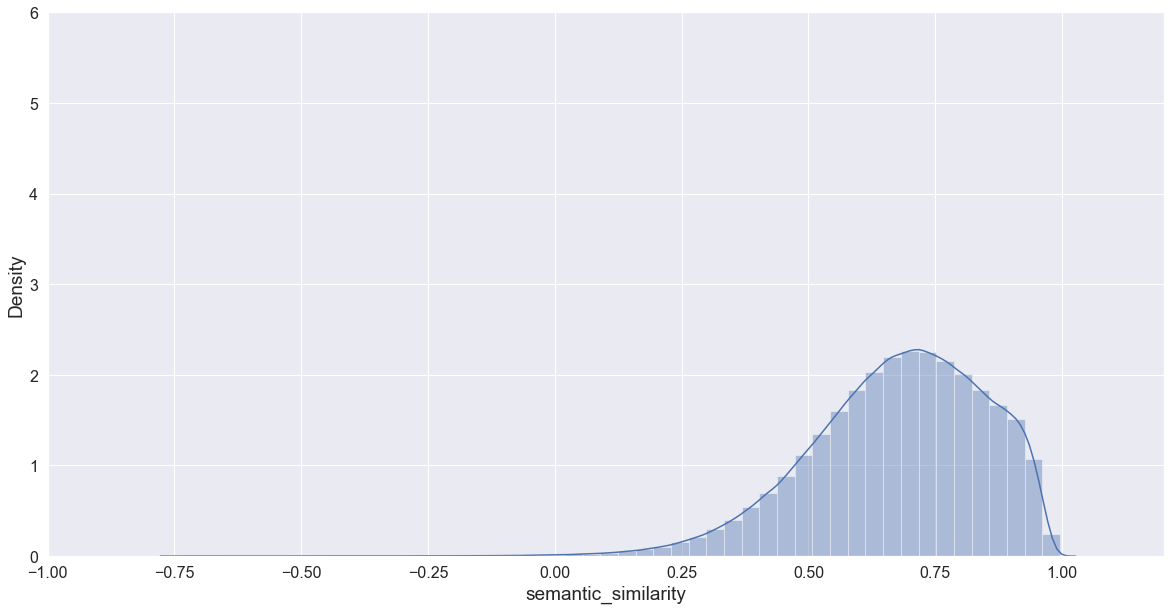

In [93]:
from matplotlib import rcParams
import seaborn as sns

fig = plt.figure()
fig.set_size_inches(20, 10)
plt.rcParams['axes.labelsize'] = 19
plt.xlim([-1,1.2])
plt.ylim((0,6))

ax = plt.gca()
ax.tick_params(axis = 'both', which = 'major', labelsize = 16)
ax.tick_params(axis = 'both', which = 'minor', labelsize = 16)

sns.distplot(swifts_PERyear_df.semantic_similarity)

/Users/furiosa/Documents/repos/paper_greekparliament/.compass/lib/python3.7/site-packages/pandas/core/arraylike.py:358: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/Users/furiosa/Documents/repos/paper_greekparliament/.compass/lib/python3.7/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:xlabel='semantic_similarity', ylabel='Density'>

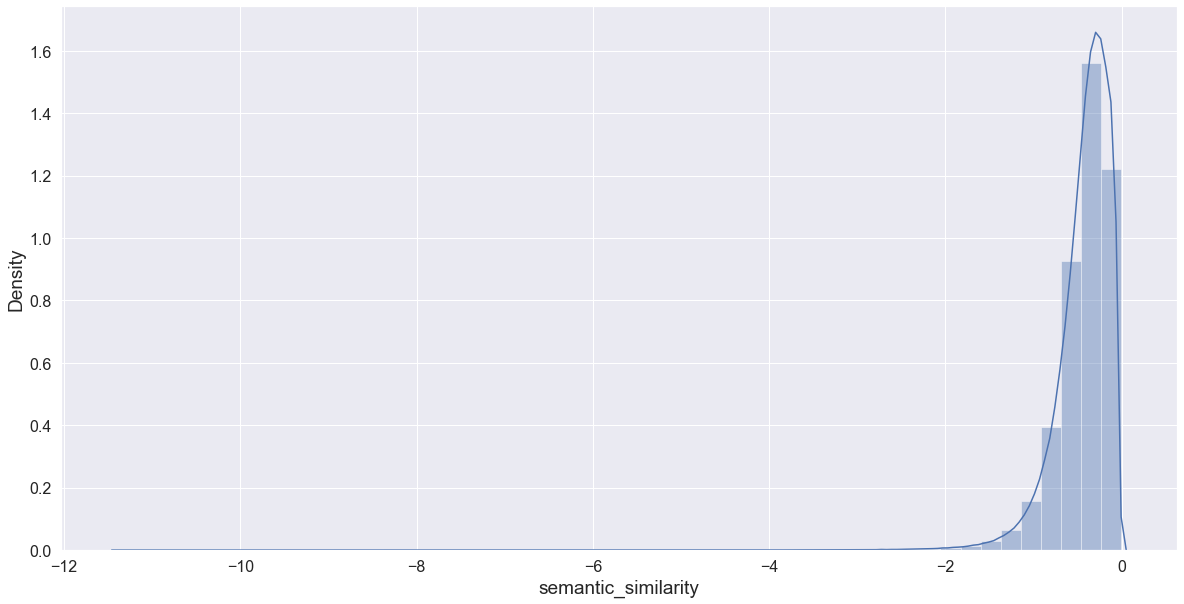

In [89]:
from matplotlib import rcParams
import seaborn as sns

fig = plt.figure()
fig.set_size_inches(20, 10)
plt.rcParams['axes.labelsize'] = 19
# plt.xlim([-1,1.2])
ax = plt.gca()
ax.tick_params(axis = 'both', which = 'major', labelsize = 16)
ax.tick_params(axis = 'both', which = 'minor', labelsize = 16)

sns.distplot(np.log(swifts_PERyear_df.semantic_similarity))

In [57]:
import matplotlib.pyplot as plt

swifts_PERyear_df.head(2)

year_pair          word  semantic_similarity  common_voc_size
327441   (1997, 1998)           529            -0.747177            44665
1390683  (2019, 2020)  παραμεριζετε            -0.707658            48506

In [58]:
sim_mean_per_year = swifts_PERyear_df.copy()
sim_mean_per_year = sim_mean_per_year.groupby(['year_pair']).agg({'semantic_similarity':'mean', 
#                          'c':'sum', 
                         'common_voc_size': lambda x: pd.Series.unique(x)
                                                                 })
# print(sim_mean_per_year.columns)
sim_mean_per_year = pd.DataFrame({'year_pair':sim_mean_per_year.index, 
                                  'mean_sim':sim_mean_per_year.semantic_similarity,
                                 'common_voc_size': sim_mean_per_year.common_voc_size
                                 }, index=None)
print(((sim_mean_per_year.columns)))
print((sim_mean_per_year.head(2)))

Index(['year_pair', 'mean_sim', 'common_voc_size'], dtype='object')
                 year_pair  mean_sim  common_voc_size
year_pair                                            
(1989, 1990)  (1989, 1990)  0.632859            31656
(1990, 1991)  (1990, 1991)  0.683310            46638


In [59]:
print((sim_mean_per_year.common_voc_size.values.tolist()))

[31656, 46638, 52582, 52344, 45337, 31532, 35560, 44665, 42800, 43505, 46073, 46595, 43661, 43567, 47665, 52105, 50365, 55265, 52452, 51140, 57919, 53576, 51563, 53683, 48401, 49164, 51479, 48927, 50130, 48506]


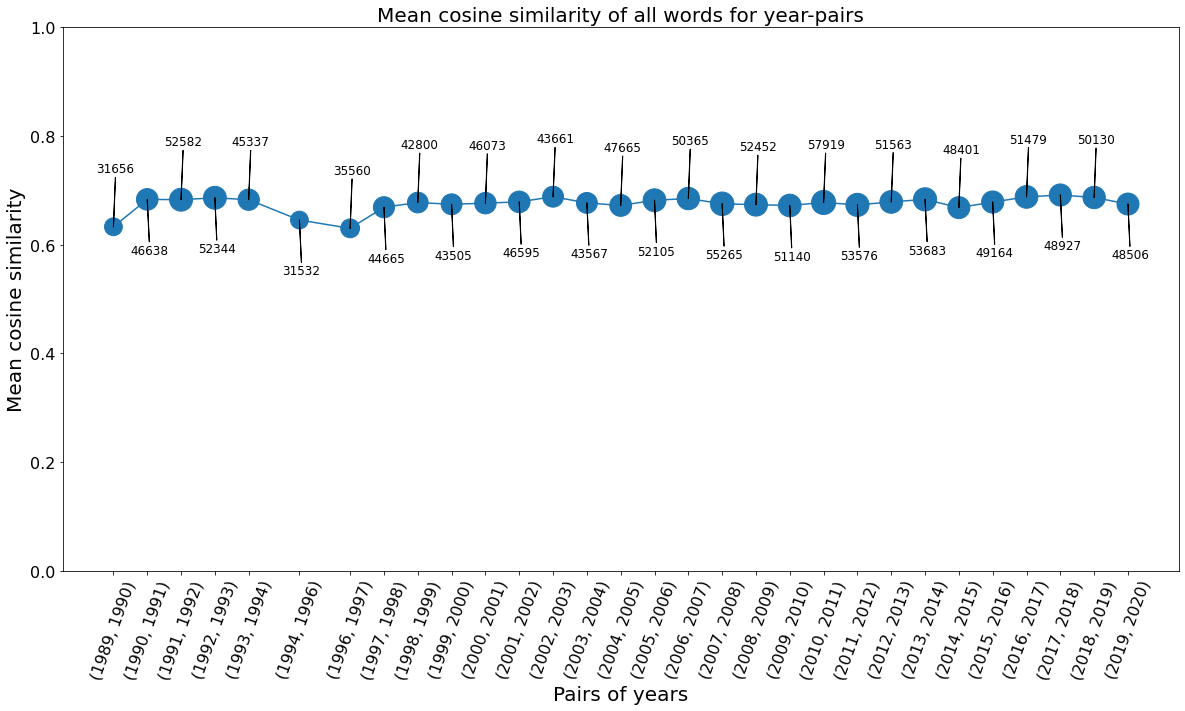

In [60]:
plt.figure(figsize=(20, 10)) 
# sim_mean_per_period = sim_mean_per_period.drop([1,4,9,12,16])
# for x,y in zip(sim_mean_per_period.years, sim_mean_per_period.mean_sim):
# plt.rcParams['axes.labelsize'] = 10
# plt.rcParams.update({'font.size': 10})
# print(sim_mean_per_year)

X = [(y[0]+y[1])/2 for y in sim_mean_per_year.year_pair.to_list()]
Y = sim_mean_per_year.mean_sim.to_list()
voc_size = [sim_mean_per_year.common_voc_size/100]

plt.scatter(X,Y, s=voc_size)
plt.xticks([(y[0]+y[1])/2 for y in sim_mean_per_year.year_pair.to_list()],sim_mean_per_year.year_pair.to_list(), rotation=70)

i=0
for size,x,y in zip(sim_mean_per_year.common_voc_size.values.tolist(), X,Y):
    if i%2==0:
        addy=0.1
    else:
        addy=-0.1
    plt.annotate(size, xy = (x,y), fontsize=12, xytext=(x-0.5, y+addy), arrowprops=dict(facecolor='black',
                                                                                       headwidth=0,
                                                                                       width=0.2))
    i+=1
    
ax = plt.gca()
ax.tick_params(axis = 'both', which = 'major', labelsize = 16)
ax.tick_params(axis = 'both', which = 'minor', labelsize = 16)

plt.ylim((0,1))

plt.title('Mean cosine similarity of all words for year-pairs', fontsize=20)
plt.ylabel('Mean cosine similarity', fontsize=20)
plt.xlabel('Pairs of years', fontsize=20)
plt.plot(X,Y)

In [104]:
PERyear_df

year                                             speech
0   1989  παρακαλειται @sw γραμματεας βουλγαρακης @sw συ...
1   1990  κυριοι συναδελφοι αρχιζει @sw συνεδριαση .\nκυ...
2   1991  κυριοι συναδελφοι αρχιζει @sw συνεδριαση .\n@s...
3   1992  κυριοι συναδελφοι αρχιζει @sw συνεδριαση .\nευ...
4   1993  κυριοι συναδελφοι αρχιζει @sw συνεδριαση .\n@s...
5   1994  κυριες @sw κυριοι συναδελφοι αρχιζει @sw συνεδ...
6   1996  παρακαλειται @sw προσωρινος γραμματεας δημητρι...
7   1997  δεχθειτε @sw @sw @sw @sw ευχες κυριε προεδρε ....
8   1998  κυριες @sw κυριοι συναδελφοι χριστος ανεστη .\...
9   1999  κυριες @sw κυριοι συναδελφοι αρχιζει @sw συνεδ...
10  2000  κυριες @sw κυριοι συναδελφοι αρχιζει @sw συνεδ...
11  2001  κυριες @sw κυριοι συναδελφοι αρχιζει @sw συνεδ...
12  2002  κυριες @sw κυριοι συναδελφοι αρχιζει @sw συνεδ...
13  2003  κυριες @sw κυριοι συναδελφοι αρχιζει @sw συνεδ...
14  2004  κυριες @sw κυριοι συναδελφοι αρχιζει @sw συνεδ...
15  2005  κυριες @sw κυριοι συναδελφοι @sw ευχομαι χρονι...
16  2006  κυριες @sw κυριοι συναδελφοι αρχιζει @sw συνεδ...
17  2007  κυριες @sw κυριοι συναδελφοι αρχιζει @sw συνεδ...
18  2008  κυριες @sw κυριοι συναδελφοι αρχιζει @sw συνεδ...
19  2009  κυριες @sw κυριοι συναδελφοι αρχιζει @sw συνεδ...
20  2010  κυριες @sw κυριοι συναδελφοι @sw @sw ευχηθω @s...
21  2011  κυριες @sw κυριοι συναδελφοι αρχιζει @sw συνεδ...
22  2012  κυριες @sw κυριοι συναδελφοι @sw @sw @sw’ αρχα...
23  2013  κυριες @sw κυριοι συναδελφοι αρχιζει @sw συνεδ...
24  2014  κυριες @sw κυριοι συναδελφοι αρχιζει @sw συνεδ...
25  2015  κυριες @sw κυριοι βουλευτες συγκαλειται @sw βο...
26  2016  αγαπητοι συναδελφοι καλημερα @sw αρχιζει @sw σ...
27  2017  κυριες @sw κυριοι συναδελφοι αρχιζει @sw συνεδ...
28  2018  κυριες @sw κυριοι συναδελφοι αρχιζει @sw συνεδ...
29  2019  κυριες @sw κυριοι συναδελφοι αρχιζει @sw συνεδ...
30  2020  κυριες @sw κυριοι συναδελφοι αρχιζει @sw συνεδ...

In [19]:
# I have updated the code up to this point

Results per decade

In [15]:
decades = [1990, 2000, 2010, 2019]
decade_pairs = step_one_pairs(decades)

swifts_PERdecade_list=[]

# aligned_models_per_year = {y:Word2Vec.load(align_dest_dir+str(y)+'.mdl') for y in years}


for pair in tqdm(decade_pairs):
    print(pair)
    
    try:
        m1 = Word2Vec.load(f"model/{pair[0]}.model")
        m2 = Word2Vec.load(f"model/{pair[1]}.model")
    except:
        continue
    common_vocab = list(set(m1.wv.vocab).intersection(set(m2.wv.vocab)))
    print(len(common_vocab))

    for word in tq.tqdm(common_vocab):

        cos_sim = compute_cosine_similarity(m1, m2, word)
        swifts_PERdecade_list.append([pair, word, cos_sim, len(common_vocab)])
                    

  0%|          | 0/3 [00:00<?, ?it/s]/Users/furiosa/Documents/repos/paper_greekparliament/.compass/lib/python3.7/site-packages/smart_open/smart_open_lib.py:410: UserWarning: This function is deprecated, use smart_open.open instead. See the migration notes for details: https://github.com/RaRe-Technologies/smart_open/blob/master/README.rst#migrating-to-the-new-open-function
  'See the migration notes for details: %s' % _MIGRATION_NOTES_URL


(1990, 2000)


/Users/furiosa/Documents/repos/paper_greekparliament/.compass/lib/python3.7/site-packages/smart_open/smart_open_lib.py:410: UserWarning: This function is deprecated, use smart_open.open instead. See the migration notes for details: https://github.com/RaRe-Technologies/smart_open/blob/master/README.rst#migrating-to-the-new-open-function
  'See the migration notes for details: %s' % _MIGRATION_NOTES_URL


35701


  0%|          | 0/35701 [00:00<?, ?it/s]

 33%|███▎      | 1/3 [00:31<01:02, 31.47s/it]/Users/furiosa/Documents/repos/paper_greekparliament/.compass/lib/python3.7/site-packages/smart_open/smart_open_lib.py:410: UserWarning: This function is deprecated, use smart_open.open instead. See the migration notes for details: https://github.com/RaRe-Technologies/smart_open/blob/master/README.rst#migrating-to-the-new-open-function
  'See the migration notes for details: %s' % _MIGRATION_NOTES_URL


(2000, 2010)


/Users/furiosa/Documents/repos/paper_greekparliament/.compass/lib/python3.7/site-packages/smart_open/smart_open_lib.py:410: UserWarning: This function is deprecated, use smart_open.open instead. See the migration notes for details: https://github.com/RaRe-Technologies/smart_open/blob/master/README.rst#migrating-to-the-new-open-function
  'See the migration notes for details: %s' % _MIGRATION_NOTES_URL


39432


  0%|          | 0/39432 [00:00<?, ?it/s]

 67%|██████▋   | 2/3 [01:32<00:49, 49.11s/it]/Users/furiosa/Documents/repos/paper_greekparliament/.compass/lib/python3.7/site-packages/smart_open/smart_open_lib.py:410: UserWarning: This function is deprecated, use smart_open.open instead. See the migration notes for details: https://github.com/RaRe-Technologies/smart_open/blob/master/README.rst#migrating-to-the-new-open-function
  'See the migration notes for details: %s' % _MIGRATION_NOTES_URL


(2010, 2019)


/Users/furiosa/Documents/repos/paper_greekparliament/.compass/lib/python3.7/site-packages/smart_open/smart_open_lib.py:410: UserWarning: This function is deprecated, use smart_open.open instead. See the migration notes for details: https://github.com/RaRe-Technologies/smart_open/blob/master/README.rst#migrating-to-the-new-open-function
  'See the migration notes for details: %s' % _MIGRATION_NOTES_URL


42467


  0%|          | 0/42467 [00:00<?, ?it/s]

100%|██████████| 3/3 [02:28<00:00, 49.50s/it]


In [16]:
swifts_PERdecade_df = pd.DataFrame(swifts_PERdecade_list, columns = ['decade_pair', 'word', 
                                                                 'semantic_similarity', 'common_voc_size'])
print(swifts_PERdecade_df.head())

    decade_pair          word  semantic_similarity  common_voc_size
0  (1990, 2000)  προσεκτικους             0.102898            35701
1  (1990, 2000)  ασφαλισμενος             0.456680            35701
2  (1990, 2000)        παρολα             0.068112            35701
3  (1990, 2000)        ομηροι             0.205180            35701
4  (1990, 2000)         οικου             0.256622            35701


In [17]:
print(swifts_PERdecade_df.describe())

swifts_PERdecade_df = swifts_PERdecade_df.sort_values('semantic_similarity')

print('Words with the lowest cosine similarity / highest change')
print(swifts_PERdecade_df.head(20))

print('Words with the highest cosine similarity / lowest change')
print(swifts_PERdecade_df.tail(20))
swifts_PERdecade_df.to_csv('../out_files/semantic_swifts_per_decade_compass.csv', index=False)

       semantic_similarity  common_voc_size
count        117600.000000    117600.000000
mean              0.207642     39395.324099
std               0.173810      2747.901588
min              -0.557604     35701.000000
25%               0.092120     35701.000000
50%               0.213073     39432.000000
75%               0.329619     42467.000000
max               0.796404     42467.000000
Words with the lowest cosine similarity / highest change
         decade_pair          word  semantic_similarity  common_voc_size
24338   (1990, 2000)        οξυνει            -0.557604            35701
66576   (2000, 2010)   διαφωνησαμε            -0.508936            39432
83819   (2010, 2019)  επιδοκιμασια            -0.503023            42467
111702  (2010, 2019)   ενεργητικες            -0.498207            42467
21632   (1990, 2000)         ανετη            -0.491993            35701
40404   (2000, 2010)     πρωτοτυπη            -0.486461            39432
44232   (2000, 2010)   απλοποιησης  

### Decade comparison before and after economic crisis

In [8]:
# crisis_df = df.copy().groupby(df.year)['speech'].progress_apply(sum).reset_index()

mask1 = (PERyear_df['year'] >= 1997) & (PERyear_df['year'] <= 2007)
corpus_before = '\n'.join([text for text in PERyear_df.loc[mask1].speech])

mask2 = (PERyear_df['year'] >= 2008) & (PERyear_df['year'] <= 2018)
corpus_after = '\n'.join([text for text in PERyear_df.loc[mask2].speech])


In [9]:
print((corpus_before[:2000]))
print(len(corpus_after))
crisis_dichotomy_df = pd.DataFrame(data=[['1997_2007', corpus_before],
                                         ['2008_2018', corpus_after]],
                                   columns = ['period', 'speech'])
crisis_dichotomy_df

δεχθειτε @sw @sw @sw @sw ευχες κυριε προεδρε .
παρακαλειται @sw κυριος γραμματεας @sw ανακοινωσει @sw @sw @sw @sw σωμα ανακοινωνονται @sw @sw σωμα @sw @sw γραμματεα @sw βουλης δημ .
κουτσογιωργα @sw ακολουθα υπουργικη αποφαση1 .
ανακοινωνεται @sw @sw υπουργος @sw οικονομικων @sw @sw @sw αριθμ .
2054525 7546 0025 20 12 96 αποφαση @sw παρεχει @sw εγγυηση @sw δημοσιου @sw τραπεζες @sw @sw χορηγηση δανειων @sw αποκατασταση @sw ζημιων @sw @sw κατολισθησεις @sw οικισμους παντανασσας @sw ατσιπαδων νομου ρεθυμνης @sw @sw @sw σεισμους @sw πολυκατοικια @sw οδου δεσποτοπουλου .
1 @sw αιγιο @sw @sw οικισμο παναγουλας @sw νομου αιτωλ νιας .
καταθεση αναφορων1 @sw βουλευτες .
δημητριος τσοβολας @sw παναγιωτης κρητικος κατεθεσαν @sw @sw @sw @sw @sw γονεις @sw κηδεμονες ατομων @sw βαρια νοητικη καθυστερηση @sw ζουν @sw νομο ημαθιας ζητουν @sw επανακαταβολη επιδοματος βοηθειας @sw βαρια νοητικα καθυστερημενα ατομα @sw δεικτη νοημοσυνης @sw 30 2 @sw προεδρος @sw @δηκκι @sw βουλευτης αθηνων δημητριος τσο

period                                             speech
0  1997_2007  δεχθειτε @sw @sw @sw @sw ευχες κυριε προεδρε ....
1  2008_2018  κυριες @sw κυριοι συναδελφοι αρχιζει @sw συνεδ...

In [10]:
compass_file_path = training_texts_dir+'crisis_dichotomy_compass.txt'


NameError: name 'training_texts_dir' is not defined

In [138]:
# print(datetime.datetime.now())

# # Create compass text
# preprocessed_corpus = '\n'.join([yearly_speech for yearly_speech in crisis_dichotomy_df.speech.to_list()])

# with open(compass_file_path, "w") as o:
#     o.write(preprocessed_corpus)
    
# aligner = CADE(size=30, siter=10, diter=10, workers=4)
# aligner.train_compass(compass_file_path, overwrite=True, save=True)

# print(datetime.datetime.now())


2021-02-10 00:21:24.946164
Training the compass from scratch.


/Users/furiosa/Documents/repos/paper_greekparliament/.compass/lib/python3.7/site-packages/smart_open/smart_open_lib.py:410: UserWarning: This function is deprecated, use smart_open.open instead. See the migration notes for details: https://github.com/RaRe-Technologies/smart_open/blob/master/README.rst#migrating-to-the-new-open-function
  'See the migration notes for details: %s' % _MIGRATION_NOTES_URL
/Users/furiosa/Documents/repos/paper_greekparliament/.compass/lib/python3.7/site-packages/smart_open/smart_open_lib.py:410: UserWarning: This function is deprecated, use smart_open.open instead. See the migration notes for details: https://github.com/RaRe-Technologies/smart_open/blob/master/README.rst#migrating-to-the-new-open-function
  'See the migration notes for details: %s' % _MIGRATION_NOTES_URL


2021-02-10 01:09:29.285248


In [11]:
training_texts_dir = 'training_texts/'
periods = crisis_dichotomy_df.period.to_list()


In [139]:
# if not os.path.exists(training_texts_dir):
#     os.makedirs(training_texts_dir)

# for period, speech in tqdm(zip(crisis_dichotomy_df.period, crisis_dichotomy_df.speech)):
#     with open(training_texts_dir+period+'.txt', "w") as o:
#         o.write(speech)      

# print(datetime.datetime.now())

# for period in tqdm(periods):
#     period_model = aligner.train_slice(training_texts_dir+period+'.txt', save=True)

# print(datetime.datetime.now())

2it [00:22, 11.41s/it]
  0%|          | 0/2 [00:00<?, ?it/s]/Users/furiosa/Documents/repos/paper_greekparliament/.compass/lib/python3.7/site-packages/smart_open/smart_open_lib.py:410: UserWarning: This function is deprecated, use smart_open.open instead. See the migration notes for details: https://github.com/RaRe-Technologies/smart_open/blob/master/README.rst#migrating-to-the-new-open-function
  'See the migration notes for details: %s' % _MIGRATION_NOTES_URL


2021-02-10 01:09:52.202894
Training embeddings: slice training_texts/1997_2007.txt.
Initializing embeddings from compass.


/Users/furiosa/Documents/repos/paper_greekparliament/.compass/lib/python3.7/site-packages/smart_open/smart_open_lib.py:410: UserWarning: This function is deprecated, use smart_open.open instead. See the migration notes for details: https://github.com/RaRe-Technologies/smart_open/blob/master/README.rst#migrating-to-the-new-open-function
  'See the migration notes for details: %s' % _MIGRATION_NOTES_URL
 50%|█████     | 1/2 [20:11<20:11, 1211.50s/it]/Users/furiosa/Documents/repos/paper_greekparliament/.compass/lib/python3.7/site-packages/smart_open/smart_open_lib.py:410: UserWarning: This function is deprecated, use smart_open.open instead. See the migration notes for details: https://github.com/RaRe-Technologies/smart_open/blob/master/README.rst#migrating-to-the-new-open-function
  'See the migration notes for details: %s' % _MIGRATION_NOTES_URL


Training embeddings: slice training_texts/2008_2018.txt.
Initializing embeddings from compass.


/Users/furiosa/Documents/repos/paper_greekparliament/.compass/lib/python3.7/site-packages/smart_open/smart_open_lib.py:410: UserWarning: This function is deprecated, use smart_open.open instead. See the migration notes for details: https://github.com/RaRe-Technologies/smart_open/blob/master/README.rst#migrating-to-the-new-open-function
  'See the migration notes for details: %s' % _MIGRATION_NOTES_URL
100%|██████████| 2/2 [39:44<00:00, 1192.32s/it]

2021-02-10 01:49:36.841270


In [14]:
swifts_crisis_dichotomy_list=[]
periods = crisis_dichotomy_df.period.to_list()

m1 = Word2Vec.load(f"model/{periods[0]}.model")
m2 = Word2Vec.load(f"model/{periods[1]}.model")

common_vocab = list(set(m1.wv.vocab).intersection(set(m2.wv.vocab)))
print(len(common_vocab))

for word in tq.tqdm(common_vocab):

    cos_sim = compute_cosine_similarity(m1, m2, word)
    swifts_crisis_dichotomy_list.append([(periods[0], periods[1]), word, cos_sim, len(common_vocab)])

/Users/furiosa/Documents/repos/paper_greekparliament/.compass/lib/python3.7/site-packages/smart_open/smart_open_lib.py:410: UserWarning: This function is deprecated, use smart_open.open instead. See the migration notes for details: https://github.com/RaRe-Technologies/smart_open/blob/master/README.rst#migrating-to-the-new-open-function
  'See the migration notes for details: %s' % _MIGRATION_NOTES_URL
/Users/furiosa/Documents/repos/paper_greekparliament/.compass/lib/python3.7/site-packages/smart_open/smart_open_lib.py:410: UserWarning: This function is deprecated, use smart_open.open instead. See the migration notes for details: https://github.com/RaRe-Technologies/smart_open/blob/master/README.rst#migrating-to-the-new-open-function
  'See the migration notes for details: %s' % _MIGRATION_NOTES_URL


141899


  0%|          | 0/141899 [00:00<?, ?it/s]

In [16]:
swifts_crisis_dichotomy_df = pd.DataFrame(swifts_crisis_dichotomy_list, columns = ['periods', 'word', 
                                                                 'semantic_similarity', 'common_voc_size'])
print(swifts_crisis_dichotomy_df.head())

                  periods          word  semantic_similarity  common_voc_size
0  (1997_2007, 2008_2018)   ακατανοητες             0.818031           141899
1  (1997_2007, 2008_2018)  λογαριασμους             0.888642           141899
2  (1997_2007, 2008_2018)    αμμουλιανη             0.405204           141899
3  (1997_2007, 2008_2018)   αντιπροεδρο             0.878031           141899
4  (1997_2007, 2008_2018)   επανεναρξης             0.527709           141899


In [159]:
# swifts_crisis_dichotomy_df.periods = '('+periods[0]+', '+periods[1]+')'

In [17]:
print(swifts_crisis_dichotomy_df.describe())

swifts_crisis_dichotomy_df = swifts_crisis_dichotomy_df.sort_values('semantic_similarity')

print('Words with the lowest cosine similarity / highest change')
print(swifts_crisis_dichotomy_df.head(50))

print('Words with the highest cosine similarity / lowest change')
print(swifts_crisis_dichotomy_df.tail(20))

# swifts_crisis_dichotomy_df.to_csv('../out_files/semantic_swifts_dichotomy_crisis_compass_1997_2007_2008_2018.csv', index=False)



       semantic_similarity  common_voc_size
count        141899.000000         141899.0
mean              0.634578         141899.0
std               0.221031              0.0
min              -0.760206         141899.0
25%               0.482603         141899.0
50%               0.656808         141899.0
75%               0.822929         141899.0
max               0.989009         141899.0
Words with the lowest cosine similarity / highest change
                       periods              word  semantic_similarity  \
23418   (1997_2007, 2008_2018)          μενουνος            -0.760206   
130389  (1997_2007, 2008_2018)      διαμειφθεντα            -0.607369   
68214   (1997_2007, 2008_2018)            τσιτση            -0.598544   
24463   (1997_2007, 2008_2018)            λεκτωρ            -0.508518   
48543   (1997_2007, 2008_2018)         ευγνωμονω            -0.492828   
47806   (1997_2007, 2008_2018)           τρενοσε            -0.491784   
14772   (1997_2007, 2008_2018)      

In [18]:
swifts_crisis_dichotomy_df.loc[(swifts_crisis_dichotomy_df.word=='κινητο')]

periods    word  semantic_similarity  common_voc_size
35949  (1997_2007, 2008_2018)  κινητο             0.937919           141899

In [15]:
swifts_crisis_dichotomy_df = pd.read_csv('../../out_files/semantic_swifts_dichotomy_crisis_compass_1997_2007_2008_2018.csv')


In [16]:
neighbor_change = []
top5words = swifts_crisis_dichotomy_df.word.head(5).to_list()
for word in top5words:
    most_similar_words_period0 = ',\n'.join([neighbor for neighbor, similarity in m1.wv.most_similar(positive=[word], topn=5)])
    most_similar_words_period1 = ',\n'.join([neighbor for neighbor, similarity in m2.wv.most_similar(positive=[word], topn=5)])
    neighbor_change.append([word, most_similar_words_period0, most_similar_words_period1, swifts_crisis_dichotomy_df.loc[(swifts_crisis_dichotomy_df.word==word), 'semantic_similarity']])
neighbor_change_df = pd.DataFrame(neighbor_change, columns = ['word', periods[0], periods[1], 'semantic_similarity'])
print(tabulate(neighbor_change_df, headers='keys', tablefmt='fancy_grid'))



╒════╤══════════════╤══════════════════╤════════════════════╤═══════════════════════╕
│    │ word         │ 1997_2007        │ 2008_2018          │   semantic_similarity │
╞════╪══════════════╪══════════════════╪════════════════════╪═══════════════════════╡
│  0 │ μενουνος     │ ξαναπιασουμε,    │ τσιτση,            │             -0.760206 │
│    │              │ κερασω,          │ πανπελοποννησιακο, │                       │
│    │              │ κοκαλακια,       │ εφροντισε,         │                       │
│    │              │ χρυσορυχειο,     │ φεισθει,           │                       │
│    │              │ ημιαπασχολουμενο │ εκπροσωπιση        │                       │
├────┼──────────────┼──────────────────┼────────────────────┼───────────────────────┤
│  1 │ διαμειφθεντα │ συνταγματικου,   │ απαιτησιν,         │             -0.607369 │
│    │              │ εφαρμοστη,       │ κοζακ,             │                       │
│    │              │ κληρονομικου,    │ κλωνους,     

In [25]:
vouliwatch_topics = ['αγροτικη', 'αγροτικα', 'αγροτες', 
          'αναπτυξη', 'επενδυσεις', 'επενδυσεων',
          'ασφαλιστικο', 'εργασια', 'εργασιακα', 'δικαιωματα', 'συμβαση', 'συλλογικη', 'μισθος', 'βασικος', 'ημιαπασχοληση', 'brain', 'οαεδ',
          'δικαιοσυνη', 'διαφανεια', 'υιοθεσια',
          'εθνικη', 'αμυνα',
          'εξωτερικη', 'διεθνεις',
          'ναυτιλια','νησια','υδροδοτηση','αλιεια',
          'οικονομια', 'αφορολογητο', 'αποκεντρωση', 'φπα', 'επιχειρησεις', 'φορολογικα', 
          'παιδεια', 'ερευνα', 'προσχολικη', 'ασυλο', 'πανεπιστημιακο', 'δευτεροβαθμια', 'πρωτοβαθμια', 'ανωτατη', 'δημοσια', 'ιδιωτικη', 'σχολες',
          'περιβαλλον', 'ενεργεια', 
          'συστημα',
          'πολιτισμος', 'αθλητισμος', 'πολιτισμο', 'αθλητισμου',
          'προστασια', 'αστυνομια', 'κοκ',
          'προσφυγικο', 'μεταναστευτικο', 
          'τουρισμος', 'τουριστικης', 'τουρισμου',
          'υγεια', 'προνοια', 'επιδοματα', 'επιδομα', 'επιδοματων',
          'υποδομες', 'μεταφορες', 'αναπλαση', #'μμμ',
          'μειωση', 'αυξηση', 'συνταξη', 'πγδμ', 'προσληψεις', 'εκασ', 'οσε', 'συγκοινωνιες', 'νομοσχεδιο', #'ομοφυλα', 'εοπυυ'
         ]

In [28]:
neighbor_change = []

for word in vouliwatch_topics:
    most_similar_words_period0 = ',\n'.join([neighbor for neighbor, similarity in m1.wv.most_similar(positive=[word], topn=5)])
    most_similar_words_period1 = ',\n'.join([neighbor for neighbor, similarity in m2.wv.most_similar(positive=[word], topn=5)])
    neighbor_change.append([word, most_similar_words_period0, most_similar_words_period1, swifts_crisis_dichotomy_df.loc[(swifts_crisis_dichotomy_df.word==word), 'semantic_similarity']])
neighbor_change_df = pd.DataFrame(neighbor_change, columns = ['word', periods[0], periods[1], 'semantic_similarity'])
print(tabulate(neighbor_change_df, headers='keys', tablefmt='fancy_grid'))


╒════╤════════════════╤═══════════════════════╤════════════════════════╤═══════════════════════╕
│    │ word           │ 1997_2007             │ 2008_2018              │   semantic_similarity │
╞════╪════════════════╪═══════════════════════╪════════════════════════╪═══════════════════════╡
│  0 │ αγροτικη       │ εμπορικη,             │ κτηνοτροφικη,          │              0.922878 │
│    │                │ κτηνοτροφικη,         │ εξαγωγικη,             │                       │
│    │                │ γεωργικη,             │ συνδεδεμενη,           │                       │
│    │                │ εξαγωγικη,            │ επενδυτικη,            │                       │
│    │                │ μικρομεσαια           │ μικρομεσαια            │                       │
├────┼────────────────┼───────────────────────┼────────────────────────┼───────────────────────┤
│  1 │ αγροτικα       │ κτηνοτροφικα,         │ γεωργικα,              │              0.935878 │
│    │                │ γεωργι

### Implementation of local neighborhood measure for semantic shift from Hamilton's paper
Section 2.1 https://www.aclweb.org/anthology/D16-1229/

Finding: as the topn increases, the average cosine similarity decreases, but more slowly in every step (for the selected topics). Over topn=50 the changes are minor.

In [107]:
vouliwatch_topics = ['αγροτικη', 'αγροτικα', 'αγροτες', 
          'αναπτυξη', 'επενδυσεις', 'επενδυσεων',
          'ασφαλιστικο', 'εργασια', 'εργασιακα', 'δικαιωματα', 'συμβαση', 'συλλογικη', 'μισθος', 'βασικος', 'ημιαπασχοληση', 'brain', 'οαεδ',
          'δικαιοσυνη', 'διαφανεια', 'υιοθεσια',
          'εθνικη', 'αμυνα',
          'εξωτερικη', 'διεθνεις',
          'ναυτιλια','νησια','υδροδοτηση','αλιεια',
          'οικονομια', 'αφορολογητο', 'αποκεντρωση', 'φπα', 'επιχειρησεις', 'φορολογικα', 
          'παιδεια', 'ερευνα', 'προσχολικη', 'ασυλο', 'πανεπιστημιακο', 'δευτεροβαθμια', 'πρωτοβαθμια', 'ανωτατη', 'δημοσια', 'ιδιωτικη', 'σχολες',
          'περιβαλλον', 'ενεργεια', 
          'συστημα',
          'πολιτισμος', 'αθλητισμος', 'πολιτισμο', 'αθλητισμου',
          'προστασια', 'αστυνομια', 'κοκ',
          'προσφυγικο', 'μεταναστευτικο', 
          'τουρισμος', 'τουριστικης', 'τουρισμου',
          'υγεια', 'προνοια', 'επιδοματα', 'επιδομα', 'επιδοματων',
          'υποδομες', 'μεταφορες', 'αναπλαση', #'μμμ',
          'μειωση', 'αυξηση', 'συνταξη', 'πγδμ', 'προσληψεις', 'εκασ', 'οσε', 'συγκοινωνιες', 'νομοσχεδιο', #'ομοφυλα', 'εοπυυ'
         ]

similarities_2nd_order = []

for topic in vouliwatch_topics:

    #union of neighbors in two points in time
    neighbors_t1 = [w for w,s in m1.wv.most_similar(positive=[topic], topn=25)]
    neighbors_t2 = [w for w,s in m2.wv.most_similar(positive=[topic], topn=25)]
    neighbors_t1_t2 = list(set(neighbors_t1+neighbors_t2))
    
    neighbors_union=[]
    # keep neighbors that are included in the compared model vocabularies
    for neighbor in neighbors_t1_t2:
        if (neighbor in m1.wv.vocab) and (neighbor in m2.wv.vocab):
            neighbors_union.append(neighbor)
#     print('Union of neighbors: ', str(len(neighbors_union)))
    
    # similarity vector for time point 1 (t1)
    # each element is the cosine similarity of topic vector in t1 and each neighbor from neighbors_union
    similarity_vector_t1 = []
    topic_vector_t1 = m1.wv[topic]
    for nn in neighbors_union:
        neighbor_vector = m1.wv[nn]
        similarity_vector_t1.append(cosine_similarity(X=topic_vector_t1.reshape(1,-1), Y=neighbor_vector.reshape(1,-1))[0][0])
#     print(len(similarity_vector_t1))
    
    # similarity vector for time point 2 (t2)
    # each element is the cosine similarity of topic vector in t2 and each neighbor from neighbors_union
    similarity_vector_t2 = []
    topic_vector_t2 = m2.wv[topic]
    for nn in neighbors_union:
        neighbor_vector = m2.wv[nn]
        similarity_vector_t2.append(cosine_similarity(X=topic_vector_t2.reshape(1,-1), Y=neighbor_vector.reshape(1,-1))[0][0])
#     print(len(similarity_vector_t2))

    #testing
#     print(similarity_vector_t1)
#     print(np.array([similarity_vector_t1]))
    # print(np.array(similarity_vector_t2).reshape(-1, 1))

    # final cosine between cosines/ similarity vectors for t1 and t2
    result = cosine_similarity(np.array([similarity_vector_t1]),
                               np.array([similarity_vector_t2])
                              )[0][0]

    similarities_2nd_order.append([topic, '1997_2007 - 2008_2018', result, len(neighbors_union), neighbors_t1, neighbors_t2])
#     break


df_similarities_2nd_order = pd.DataFrame(data=similarities_2nd_order, columns=['topic', 'time_points', 'cosine_similarity', 'neighbors_union', 'neighbors_before', 'neighbors_after'])

df_similarities_2nd_order = df_similarities_2nd_order.sort_values('cosine_similarity', ascending=True).reset_index(drop=True)
print(df_similarities_2nd_order.head(5))
df_similarities_2nd_order.describe()

           topic            time_points  cosine_similarity  neighbors_union  \
0          brain  1997_2007 - 2008_2018           0.229136               45   
1     προσφυγικο  1997_2007 - 2008_2018           0.689209               49   
2           εκασ  1997_2007 - 2008_2018           0.771997               43   
3  ημιαπασχοληση  1997_2007 - 2008_2018           0.847823               50   
4         μισθος  1997_2007 - 2008_2018           0.878270               39   

                                    neighbors_before  \
0  [αναγεγραμμενο, ημιαυτοματο, χακερ, scanners, ...   
1  [ανεπιθυμητο, ρακενδυτος, οθωμανικο, ακηρυχτο,...   
2  [συνταξεων, αποδοχων, επιδοματων, επιδοματος, ...   
3  [ασφαλιστεων, ασφαλιζομενους, τριανταωρο, αυτο...   
4  [μηνιαιος, κατωτερος, ανθυπολοχαγου, κατωτατος...   

                                     neighbors_after  
0  [drain, gain, εγκεφαλων, μυαλων, εκτραχυνση, τ...  
1  [μεταναστευτικο, λαθρομεταναστευτικο, εκρηκτικ...  
2  [φιλοδωρημα, αντιμισ

cosine_similarity  neighbors_union
count          77.000000        77.000000
mean            0.927190        39.831169
std             0.093869         3.679254
min             0.229136        32.000000
25%             0.912295        37.000000
50%             0.945507        40.000000
75%             0.969042        41.000000
max             0.991956        50.000000

In [108]:
df_similarities_2nd_order.neighbors_before = df_similarities_2nd_order.neighbors_before.apply(lambda x: ',\n'.join([nn for nn in x]))
df_similarities_2nd_order.neighbors_after = df_similarities_2nd_order.neighbors_after.apply(lambda x: ',\n'.join([nn for nn in x]))
del df_similarities_2nd_order['time_points']
print(tabulate(df_similarities_2nd_order, headers='keys', tablefmt='fancy_grid'))


╒════╤════════════════╤═════════════════════╤═══════════════════╤═══════════════════════╤═════════════════════════╕
│    │ topic          │   cosine_similarity │   neighbors_union │ neighbors_before      │ neighbors_after         │
╞════╪════════════════╪═════════════════════╪═══════════════════╪═══════════════════════╪═════════════════════════╡
│  0 │ brain          │            0.229136 │                45 │ αναγεγραμμενο,        │ drain,                  │
│    │                │                     │                   │ ημιαυτοματο,          │ gain,                   │
│    │                │                     │                   │ χακερ,                │ εγκεφαλων,              │
│    │                │                     │                   │ scanners,             │ μυαλων,                 │
│    │                │                     │                   │ σκαρτο,               │ εκτραχυνση,             │
│    │                │                     │                   │ ευφλεκ

/Users/furiosa/Documents/repos/paper_greekparliament/.compass/lib/python3.7/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:title={'center':'Semantic similarity distribution (before and after crisis)'}, xlabel='semantic_similarity', ylabel='Density'>

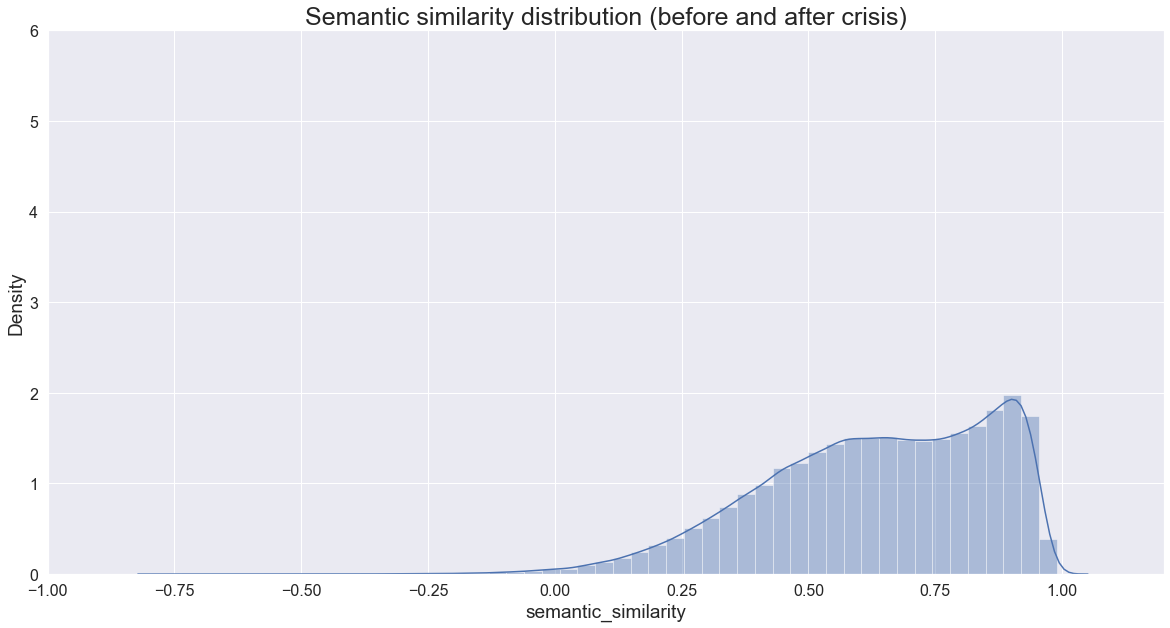

In [293]:
from matplotlib import rcParams
import seaborn as sns

fig = plt.figure()
fig.set_size_inches(20, 10)
plt.rcParams['axes.labelsize'] = 19
plt.xlim([-1,1.2])
plt.ylim((0,6))
plt.title('Semantic similarity distribution (before and after crisis)', fontsize=25)
ax = plt.gca()
ax.tick_params(axis = 'both', which = 'major', labelsize = 16)
ax.tick_params(axis = 'both', which = 'minor', labelsize = 16)

sns.distplot(swifts_crisis_dichotomy_df.semantic_similarity)

### Take into account word frequency

In [18]:
freq_df = pd.read_csv('../../out_files/freqs_for_semantic_shift_cleaned_data.csv')
freq_df = freq_df.sort_values('frequency', ascending=False).reset_index(drop=True)

print(freq_df.shape)
# print(freq_df.frequency.to_list())

(520787, 3)


In [ ]:
#not working, sth wrong

from matplotlib import rcParams
import seaborn as sns

fig = plt.figure()
fig.set_size_inches(20, 10)
plt.rcParams['axes.labelsize'] = 19
# plt.xlim([9418895,94188954])
# plt.ylim((0,100))

ax = plt.gca()
ax.tick_params(axis = 'both', which = 'major', labelsize = 16)
ax.tick_params(axis = 'both', which = 'minor', labelsize = 16)

sns.histplot(freq_df.frequency)

In [19]:
pd.set_option('float_format', '{:f}'.format)

In [20]:
freq_df.describe()

frequency    percentage
count   520787.000000 520787.000000
mean       334.207448      0.000002
std     130542.425190      0.000746
min          1.000000      0.000000
25%          1.000000      0.000000
50%          2.000000      0.000000
75%         10.000000      0.000000
max   94188954.000000      0.537940

In [21]:
freq_subdf = freq_df.loc[(freq_df.frequency>334)]
print(freq_subdf.shape)
freq_subdf = freq_subdf.reset_index(drop=True)
print(freq_subdf.tail(2))

(21792, 3)
             word  frequency  percentage
21790      αδικοι        335    0.000002
21791  σημειωσετε        335    0.000002


In [23]:
# swifts_crisis_dichotomy_df = swifts_crisis_dichotomy_df.reset_index(drop=True)

shifts_frequent_words = swifts_crisis_dichotomy_df.loc[(swifts_crisis_dichotomy_df.word.isin(freq_subdf.word.to_list()))].reset_index(drop=True)

# add columns frequency and percentage in shifts_frequent_words based on the value of column word
shifts_frequent_words = pd.merge(shifts_frequent_words, freq_subdf, on=['word'], how='left')   

print(shifts_frequent_words.head(10))

print(shifts_frequent_words.tail(2))

shifts_frequent_words.describe()


                      periods       word  semantic_similarity  \
0  ('1997_2007', '2008_2018')       4387            -0.203762   
1  ('1997_2007', '2008_2018')    κουρεμα            -0.195695   
2  ('1997_2007', '2008_2018')      5ετια            -0.068619   
3  ('1997_2007', '2008_2018')  κουναλακη            -0.058060   
4  ('1997_2007', '2008_2018')        εκμ            -0.052398   
5  ('1997_2007', '2008_2018')      βιτσα            -0.030004   
6  ('1997_2007', '2008_2018')       κεπα            -0.022278   
7  ('1997_2007', '2008_2018')        psi            -0.016759   
8  ('1997_2007', '2008_2018')    γευματα            -0.012587   
9  ('1997_2007', '2008_2018')       15ος            -0.005383   

   common_voc_size  frequency  percentage  
0           141899        408    0.000002  
1           141899       1753    0.000010  
2           141899        343    0.000002  
3           141899        357    0.000002  
4           141899        341    0.000002  
5           141899  

semantic_similarity  common_voc_size     frequency   percentage
count         21607.000000     21607.000000  21607.000000 21607.000000
mean              0.884409    141899.000000   3307.607211     0.000019
std               0.095181         0.000000  11952.854006     0.000068
min              -0.203762    141899.000000    335.000000     0.000002
25%               0.867845    141899.000000    522.000000     0.000003
50%               0.908965    141899.000000    927.000000     0.000005
75%               0.935510    141899.000000   2274.000000     0.000013
max               0.989009    141899.000000 761277.000000     0.004348

<AxesSubplot:xlabel='semantic_similarity', ylabel='Count'>

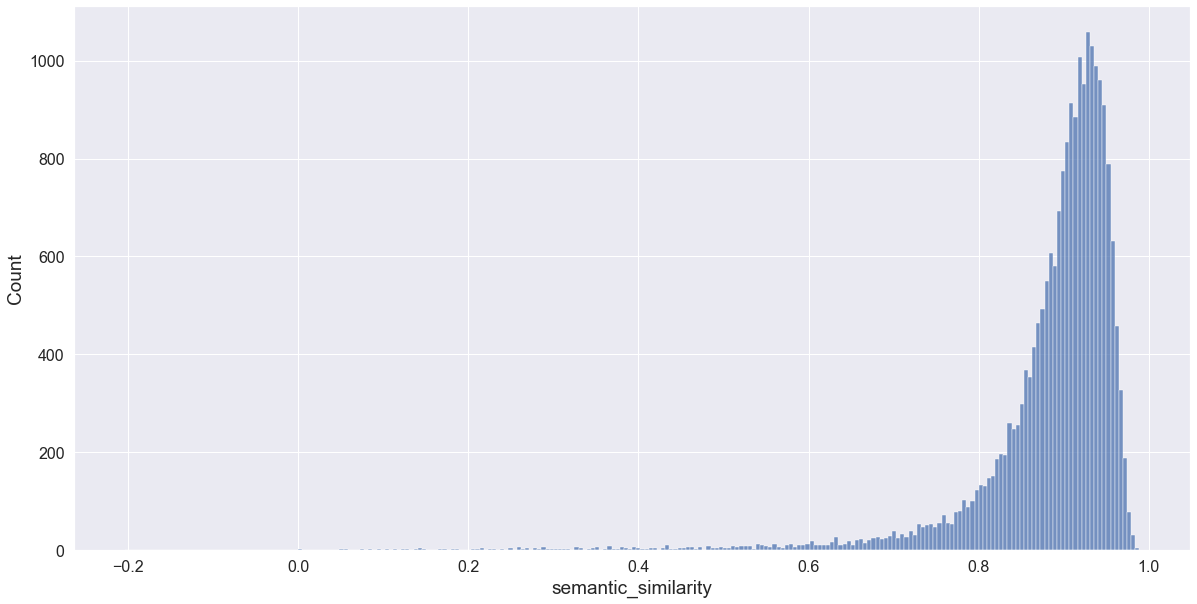

In [268]:

from matplotlib import rcParams
import seaborn as sns

fig = plt.figure()
fig.set_size_inches(20, 10)
plt.rcParams['axes.labelsize'] = 19
# plt.xlim([9418895,94188954])
# plt.ylim((0,100))

ax = plt.gca()
ax.tick_params(axis = 'both', which = 'major', labelsize = 16)
ax.tick_params(axis = 'both', which = 'minor', labelsize = 16)

sns.histplot(shifts_frequent_words.semantic_similarity)

In [24]:
shifts_frequent_words.loc[(shifts_frequent_words.semantic_similarity <= 0.2)].head(2)

periods     word  semantic_similarity  common_voc_size  \
0  ('1997_2007', '2008_2018')     4387            -0.203762           141899   
1  ('1997_2007', '2008_2018')  κουρεμα            -0.195695           141899   

   frequency  percentage  
0        408    0.000002  
1       1753    0.000010

In [286]:
neighbor_change = []

for word in shifts_frequent_words.loc[(shifts_frequent_words.semantic_similarity <= 0.2)].word.to_list():
#     print(word)
#     break
    most_similar_words_period0 = ',\n'.join([neighbor for neighbor, similarity in m1.wv.most_similar(positive=[word], topn=10)])
    most_similar_words_period1 = ',\n'.join([neighbor for neighbor, similarity in m2.wv.most_similar(positive=[word], topn=10)])
    neighbor_change.append([word, most_similar_words_period0, most_similar_words_period1, swifts_crisis_dichotomy_df.loc[(swifts_crisis_dichotomy_df.word==word), 'semantic_similarity']])

neighbor_change_df = pd.DataFrame(neighbor_change, columns = ['word', periods[0], periods[1], 'semantic_similarity'])
print(tabulate(neighbor_change_df, headers='keys', tablefmt='fancy_grid'))

#     print(swifts_crisis_dichotomy_df.loc[(swifts_crisis_dichotomy_df.word==word), 'semantic_similarity'].iloc[0])
#     print(shifts_frequent_words.loc[(shifts_frequent_words.word==word), 'semantic_similarity'].iloc[0])
#     break




╒════╤══════════════╤════════════════════════╤════════════════════════╤═══════════════════════╕
│    │ word         │ 1997_2007              │ 2008_2018              │   semantic_similarity │
╞════╪══════════════╪════════════════════════╪════════════════════════╪═══════════════════════╡
│  0 │ 4387         │ 5613,                  │ 4430,                  │          -0.203762    │
│    │              │ 4474,                  │ 3865,                  │                       │
│    │              │ 9056,                  │ 4472,                  │                       │
│    │              │ βαθμ,                  │ 4375,                  │                       │
│    │              │ 2178,                  │ 4093,                  │                       │
│    │              │ 4117,                  │ 4024,                  │                       │
│    │              │ χαμοζωη,               │ 4369,                  │                       │
│    │              │ περιγελουν,       

In [33]:
neighbor_change = []

for word in shifts_frequent_words.loc[(shifts_frequent_words.semantic_similarity <= 0.2)].word.to_list():
#     print(word)
#     break
    most_similar_words_period0 = ',\n'.join([neighbor for neighbor, similarity in m1.wv.most_similar(positive=[word], topn=10)])
    most_similar_words_period1 = ',\n'.join([neighbor for neighbor, similarity in m2.wv.most_similar(positive=[word], topn=10)])
    neighbor_change.append([word, most_similar_words_period0, most_similar_words_period1, swifts_crisis_dichotomy_df.loc[(swifts_crisis_dichotomy_df.word==word), 'semantic_similarity']])

neighbor_change_df = pd.DataFrame(neighbor_change, columns = ['word', periods[0], periods[1], 'semantic_similarity'])
# print(tabulate(neighbor_change_df, headers='keys', tablefmt='fancy_grid'))

#     print(swifts_crisis_dichotomy_df.loc[(swifts_crisis_dichotomy_df.word==word), 'semantic_similarity'].iloc[0])
#     print(shifts_frequent_words.loc[(shifts_frequent_words.word==word), 'semantic_similarity'].iloc[0])
#     break
print(neighbor_change_df.columns)


Index(['word', '1997_2007', '2008_2018', 'semantic_similarity'], dtype='object')


In [34]:
for index, row in neighbor_change_df.iterrows():
    print('word ', row.word)
    print(row['1997_2007'])
    print('---')
    print(row['2008_2018'])
    print(row.semantic_similarity)
    print('||||||||||||||||||||||||||||')

word  4387
5613,
4474,
9056,
βαθμ,
2178,
4117,
χαμοζωη,
περιγελουν,
3613,
θρησκος
---
4430,
3865,
4472,
4375,
4093,
4024,
4369,
4336,
4389,
3986
87   -0.203762
Name: semantic_similarity, dtype: float64
||||||||||||||||||||||||||||
word  κουρεμα
ονομαζομενος,
καημενου,
δεκαεξαχρονου,
γκαντι,
δεκαεξαρηδες,
ξαναπροσπαθησει,
καταστασις,
therapy,
παρατεινεις,
κοπανατζης
---
haircut,
επαναγορα,
μορατοριουμ,
psi,
κουρεματα,
ανακεφαλαιωση,
κουρευτει,
αναχρηματοδοτηση,
διαγραφη,
κουρεματος
94   -0.195695
Name: semantic_similarity, dtype: float64
||||||||||||||||||||||||||||
word  5ετια
ναυλωσης,
υπολογισθηκε,
προσαυξηση,
ημερολογιακο,
αναπροσαρμοζεται,
γινομενο,
διανυθεντα,
κλιμακουμενο,
πεντηκοστα,
τμηματικως
---
νοικοκυρεμενες,
ταμει,
προσανατολιζετε,
προτρεξουν,
σφαχτουν,
συμπεριλαμβανοντουσαν,
εγκαθετες,
θριαμβολογησατε,
τολμηροτερες,
ραδιοτηλεγραφητες
358   -0.068619
Name: semantic_similarity, dtype: float64
||||||||||||||||||||||||||||
word  κουναλακη
καρακωστα,
δραγασακη,
κανταρτζη,
ιντζ

In [ ]:
vouliwatch_topics = ['αγροτικη', 'αγροτικα', 'αγροτες', 
          'αναπτυξη', 'επενδυσεις', 'επενδυσεων',
          'ασφαλιστικο', 'εργασια', 'εργασιακα', 'δικαιωματα', 'συμβαση', 'συλλογικη', 'μισθος', 'βασικος', 'ημιαπασχοληση', 'brain', 'οαεδ',
          'δικαιοσυνη', 'διαφανεια', 'υιοθεσια',
          'εθνικη', 'αμυνα',
          'εξωτερικη', 'διεθνεις',
          'ναυτιλια','νησια','υδροδοτηση','αλιεια',
          'οικονομια', 'αφορολογητο', 'αποκεντρωση', 'φπα', 'επιχειρησεις', 'φορολογικα', 
          'παιδεια', 'ερευνα', 'προσχολικη', 'ασυλο', 'πανεπιστημιακο', 'δευτεροβαθμια', 'πρωτοβαθμια', 'ανωτατη', 'δημοσια', 'ιδιωτικη', 'σχολες',
          'περιβαλλον', 'ενεργεια', 
          'συστημα',
          'πολιτισμος', 'αθλητισμος', 'πολιτισμο', 'αθλητισμου',
          'προστασια', 'αστυνομια', 'κοκ',
          'προσφυγικο', 'μεταναστευτικο', 
          'τουρισμος', 'τουριστικης', 'τουρισμου',
          'υγεια', 'προνοια', 'επιδοματα', 'επιδομα', 'επιδοματων',
          'υποδομες', 'μεταφορες', 'μμμ', 'αναπλαση',
          'μειωση', 'αυξηση', 'συνταξη', 'ομοφυλα', 'ΠΓΔΜ', 'προσληψεις', 'εκασ', 'εοπυυ', 'οσε', 'συγκοινωνιες', 'νομοσχεδιο'
         ]

ΑΓΡΟΤΙΚΗ ΠΟΛΙΤΙΚΗ
ΑΝΑΠΤΥΞΗ • ΕΠΕΝΔΥΣΕΙΣ (Ανάπτυξη / Επενδύσεις)
ΑΣΦΑΛΙΣΤΙΚΟ • ΕΡΓΑΣΙΑ (Εργασιακά Δικαιώματα / ΣΣΕ, Ασφαλιστικό, Βασικός Μισθός / Ημιαπασχόληση, Brain Drain, ΟΑΕΔ)
ΔΙΚΑΙΟΣΥΝΗ • ΔΙΑΦΑΝΕΙΑ • ΔΙΚΑΙΩΜΑΤΑ (Δικαιοσύνη-Διαφάνεια-Δικαιώματα, Υιοθεσία)
ΕΘΝΙΚΗ ΑΜΥΝΑ (Εθνική Άμυνα)
ΕΞΩΤΕΡΙΚΗ ΠΟΛΙΤΙΚΗ (Διεθνείς Σχέσεις)
ΝΑΥΤΙΛΙΑ • ΝΗΣΙΑ  (Υδροδότηση, Αλιεία)
ΟΙΚΟΝΟΜΙΑ (Αφορολόγητο, Αποκέντρωση, ΦΠΑ στα νησιά, Μικρές & Μεσαίες Επιχειρήσεις, Φορολογικά)
ΠΑΙΔΕΙΑ • ΕΡΕΥΝΑ (Κοινωνικά Θέματα, Προσχολική Αγωγή, Πανεπιστημιακό Άσυλο, Δευτεροβάθμια Εκπαίδευση, Πρωτοβάθμια Εκπαίδευση, Δημόσια / Ιδιωτική Ανώτατη Εκπαίδευση, Εισαγωγή στην Ανώτατη Εκπαίδευση, Τεχνικές και Επαγγελματικές Σχολές)
ΠΕΡΙΒΑΛΛΟΝ • ΕΝΕΡΓΕΙΑ (Περιβάλλον)   
ΠΟΛΙΤΙΚΟ ΣΥΣΤΗΜΑ (Πολιτικό Σύστημα)
ΠΟΛΙΤΙΣΜΟΣ • ΑΘΛΗΤΙΣΜΟΣ (Πολιτισμός/Αθλητισμός)
ΠΡΟΣΤΑΣΙΑ ΤΟΥ ΠΟΛΙΤΗ (Αστυνομία/ΚΟΚ)
ΠΡΟΣΦΥΓΙΚΟ • ΜΕΤΑΝΑΣΤΕΥΤΙΚΟ (Μεταναστευτικό)
ΤΟΥΡΙΣΜΟΣ (Τουρισμός)
ΥΓΕΙΑ • ΠΡΟΝΟΙΑ (Κοινωνικά Επιδόματα, Υγεία/Πρόνοια, Επιδόματα, Πρόνοια)
ΥΠΟΔΟΜΕΣ • ΜΕΤΑΦΟΡΕΣ (Μ.Μ.Μ., Μεταφορές, Δίκτυα Επικοινωνίας,Ανάπλαση αστικών κέντρων)
        